In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import re
#pd.set_option('display.max_rows', 100)
from IPython.display import display

In [2]:
def read_league_data(file="2017-summer-match-data-OraclesElixir-2017-08-07.csv",path="C:/Users/joey_/__notebooks__/_python/LoL_game_prediction/",delim=','):
    return convert_leaguenames(pd.read_csv(path+file, encoding = "ISO-8859-1",delimiter=delim))
    
def round_weeks(data):
    try:
        data.loc[:,"week"] = data["week"].astype(np.double).round()
    except ValueError:
        data.loc[:,"week"] = pd.to_numeric(data["week"],errors="coerce").round()
    data = data.dropna(subset=["week"])
    return data

def iter_weeks(data):
    for indexes, df in data.groupby("week"):
        yield df

def iter_games(data):
    data = data.set_index(["week","gameid","game","split"]) # weird bug where sometimes gameid is not unique
    for indexes, df in data.groupby(level=["week","gameid","game","split"]):
        yield df.reset_index()

#input a gameDF and a teamDF   
def add_players(game,team):
    game = game.reset_index().set_index(["team","playerid"])
    players = game.xs(team["team"],level="team")
    players = players.drop(team.name)
    newcols = pd.Series(players["champion"].values,players["position"].values)
    team = team.append(newcols)
    return team.to_frame().T
    
def summarize_game(game):
    game = game.set_index(["playerid"])
    team1 = game.xs(100)#level=["playerid"]
    team2 = game.xs(200)#,level=["playerid"]
    teamnames = sorted([str(team1["team"]), str(team2["team"])])
    versus = teamnames[0] + "~" + teamnames[1]
    print(versus)
    matchup_series = pd.Series([versus],index=["matchup"])
    team1 = pd.concat([team1,matchup_series],ignore_index=False)
    team1.name = 100
    team2 = pd.concat([team2,matchup_series],ignore_index=False)
    team2.name = 200
    #team1.set_value("matchup",versus) -- so much slower
    #team2 = team2.set_value("matchup", versus) -- so much slower
    team1 = add_players(game,team1)
    team2 = add_players(game,team2)
    team1 = add_opp_stats(team1,team2)
    team2 = add_opp_stats(team2,team1)
    return team1, team2

def summarize_all_games(league):
    all_games = []
    for game in iter_games(league):
        #print(game)
        teams = summarize_game(game)
        all_games.append(teams[0])
        all_games.append(teams[1])
    return pd.concat(all_games)

def add_opp_stats(team,opp, features=["cspm","dmgtochamps","dmgtochampsperminute","earnedgpm","team",'wards','wardkills']):
    #'cspm' 'dmgtochamps' 'dmgtochampsperminute' 'earnedgpm'
    newcols = opp[features]
    newcols = newcols.add_prefix("opp_")
    team = pd.concat([team,newcols],axis=1)
    return team

def assign_matches(league):
    #league['week'].astype(str) + 
    #league['date'].dt.weekday_name + league['date'].dt.month.astype(str)
    league.loc[:,"matchID"] = ( league['date'].astype(str) + league['matchup'].str.strip() + league["league"] + league["split"].astype(str)).astype('category').cat.codes
    league = set_unique_gameid(league)
    league = league.sort_values(['week','matchID'],ascending=True)
    league = league.set_index(['team','week','matchID','game'])
    for indexes, df in league.groupby(level=['team']):
        league.loc[df.index.values,'team_match_num'] = pd.Series(df.index.get_level_values('matchID')).astype('category').cat.codes.values
        league.loc[df.index.values,'team_game_num'] = (pd.Series(df.index.get_level_values('matchID')).astype('str') + pd.Series(df.index.get_level_values('game')).astype('str')).astype('category').cat.codes.values
    return league.reset_index()

def set_match_wins(league):
    league = league.set_index(["matchID","gameid2","team"]) #unique IDs
    '''
    _ = league.groupby(level=["matchID","team"])['result'].sum()
    print(_.index)
    stop
    print(league.loc[(slice(None), _.index)])
    print(league.loc[_.index,:])
    stop
    league.loc[_.index, 'matchResult'] = (_.values > 1).astype(int)
    '''
    for indexes, df in league.groupby(level=["matchID","team"]):
        #print(indexes)
        league.loc[df.index,"matchResult"] = int(df["result"].sum() > 1)
    return league.reset_index()

def set_unique_gameid(leagues):
    leagues.loc[:,'gameid2'] =(leagues['matchID'].astype(str) + '_' + leagues['game'].astype(str) + '_' + leagues['week'].astype(str)+ '_' + leagues['split'].astype(str)+ '_' + leagues['league'].astype(str)).astype('category').cat.codes
    return leagues

def process_league(data, league="NALCS", summarize=True, set_matches=False, k=20, split="2017-1"):
    lg = data.loc[data["league"] == league.upper()]
    lg = round_weeks(lg)
    #lg = harmonize_teamnames(lg)
    lg.loc[:,"date"] = pd.to_datetime(lg["date"])
    lg.loc[:,"split"] = split
    if summarize:
        lg = summarize_all_games(lg)
        if set_matches:
            lg = assign_matches(lg)
            lg = set_match_wins(lg)
            lg = calculate_all_elo2(lg,k=k)
    return lg

def combine_leagues(leagues,set_matches=True,unify_names=True,k=20):
    leagues = pd.concat(leagues,sort=True)
    if set_matches:
        print("assigning matches...")
        leagues = assign_matches(leagues)
        print("seting match wins...")
        leagues = set_match_wins(leagues)
        print("calculating elo...")
        leagues = calculate_all_elo2(leagues,k=k)
        print()
    if unify_names:
        process_teamnames(leagues,team_names_col='team')
        process_teamnames(leagues,team_names_col='opp_team')
        process_teamnames(leagues,team_names_col='matchup')
    return leagues

def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def delta_elo(exp, score, k=32):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 32)
    """
    return k * (score - exp)

'''
input team DFs for specific matchup
'''
def calculate_delta_elo(team1_elo, team2_elo, team1_result,k=20):
    e = expected(team1_elo,team2_elo)
    re = int(team1_result)
    dElo = delta_elo(e,re,k=k)
    return dElo

def get_prev_match_elo(team,league,teamname,matchnum):
    if matchnum > 0:
        index =(teamname,matchnum - 1)
        print(index)
    else:
        index = (teamname,matchnum)
    return league.at[index,'elo'][0]

def get_match_elo(team,league,teamname,matchnum):
    index = (teamname,matchnum)
    return league.at[index,'elo'][0]
    
def calculate_all_elo(league,k=20):
    league.loc[:,'elo'] = 1600
    league = league.sort_values(by=['week','team_match_num'],ascending=True)
    league = league.set_index(['team','team_match_num'])
    for indexes, df in league.groupby(['week','matchID','matchup']):
        print(indexes)
        matchup = indexes[2].split("~")
        team1 = df.xs(matchup[0],level='team')
        team2 = df.xs(matchup[1],level='team')
        num1 = team1.index.get_level_values('team_match_num')[0]
        num2 = team2.index.get_level_values('team_match_num')[0]
        result = team1.at[num1,'matchResult'][0]
        team1_elo = get_prev_match_elo(team1,league,matchup[0],num1)
        team2_elo = get_prev_match_elo(team2,league,matchup[1],num2)
        dElo = calculate_delta_elo(team1_elo,team2_elo,result)
        league.at[(matchup[0],num1),'elo'] = get_prev_match_elo(team1,league,matchup[0],num1) + dElo
        league.at[(matchup[1],num2),'elo'] = get_prev_match_elo(team2,league,matchup[1],num2) - dElo
    return league.reset_index()

def calculate_all_elo2(league,k=20):
    league.loc[:,'elo'] = 1600
    league = league.sort_values(by=['week','team_match_num'],ascending=True)
    teams = league['team'].unique()
    league = league.set_index(['gameid2','team'])
    elo_db = pd.Series([1600]*len(teams),index=teams)
    #count = 0
    for indexes, df in league.groupby(['week','gameid2','split']):
        #count += 1
        gameid = indexes[1]
        #get teams
        vs = df.index.get_level_values('team').values
        tm1 = vs[0]
        tm2 = vs[1]
        won = df.xs(tm1,level='team')['result'].values[0]
        
        #calculate elo
        tm1_elo = elo_db[tm1]
        tm2_elo = elo_db[tm2]
        dElo = calculate_delta_elo(tm1_elo, tm2_elo, won,k=20)
        
        #update elo
        tm1_elo += dElo
        tm2_elo -= dElo
        
        league.at[(gameid,tm1),'elo'] = tm1_elo
        league.at[(gameid,tm2),'elo'] = tm2_elo
        elo_db[tm1] = tm1_elo
        elo_db[tm2] = tm2_elo
        
    league = league.reset_index()
    return league
        
        #if count == 20:
            #print(league.loc[(gameid,tm1),'elo'])


def calculate_champion_elo(league,positions=['Support','Top','Middle','ADC','Jungle'],k=20):
    for pos in positions:
        print('position: ', pos)
        champions = league[pos].unique()
        elo_db = pd.Series([1600]*len(champions),index=champions)
        #league.loc[:,pos+'_elo'] = 1600
        league = league.sort_values(by=['week','team_match_num'],ascending=True)
        league = league.set_index([pos,'gameid2'])
        
        league = league.sort_index(level=league.index.names) # address performance warning
        for indexes, df in league.groupby(['week','matchID','gameid2','split']):
            champs = df.index.get_level_values(pos)
            #print(champs)
            champ_1_key = champs[0]
            champ_2_key = champs[1]
            champ1_win = df.iloc[0]['result']
            x = calculate_delta_elo(elo_db[champ_1_key],elo_db[champ_2_key],champ1_win)
            elo_db[champ_1_key] += x
            elo_db[champ_2_key] -= x
            league.at[(champ_1_key,indexes[2]),pos+'_elo'] = elo_db[champ_1_key]
            league.at[(champ_2_key,indexes[2]),pos+'_elo'] = elo_db[champ_2_key]
        league = league.reset_index()
    return league

def calculate_net_features(leagues,pairs=[('wards','wardkills','net_wards')],normalize=False):
    for pair in pairs:
        leagues.loc[:,pair[2]] = leagues.loc[:,pair[0]] - leagues.loc[:,pair[1]]
        if normalize:
            leagues = normalize_by_gamelength(leagues,pair[2])
    return leagues

def calculate_ward_score(leagues):
    '''
    ward_score = (wards - opp_wardkills) / (opp_wards - wardkills)
    
    if ward_score > 1: team has better vision
    if ward scare < 1: opp_team has better vision
    '''
    leagues = calculate_net_features(leagues,pairs=[('wards','opp_wardkills','net_wards')],normalize=True)
    leagues = calculate_net_features(leagues,pairs=[('opp_wards','wardkills','opp_net_wards')],normalize=True)
    leagues.loc[:,'vision_score'] = leagues['net_wards'] / leagues['opp_net_wards']
    return leagues
    
    
def normalize_by_gamelength(leagues,var,gamelength='gamelength'):
    leagues.loc[:,var+"_per_min"] = leagues.loc[:,var] / leagues[gamelength]
    return leagues


def calculate_draft_score(leagues,positions=['Support','Top','Middle','ADC','Jungle'],k=20,weights={'Support_elo' : 1,
                                                                                                   'Top_elo': 1,
                                                                                                   'Middle_elo' : 1,
                                                                                                   'ADC_elo' : 1,
                                                                                                   'Jungle_elo' : 1}):
    leagues = calculate_champion_elo(leagues,positions=positions)
    leagues.loc[:,'draft_score'] = leagues[list(weights.keys())].dot(list(weights.values())) / len(weights.values())
    return leagues
    
def calculate_secondary_features(leagues):
    leagues = calculate_ward_score(leagues)
    leagues = calculate_draft_score(leagues)
    leagues.loc[:,'kda'] = ((leagues['k'] + leagues['a']) / leagues['d']).replace([np.inf, -np.inf], np.nan)
    leagues.loc[:,'kda2'] = (leagues['k'] + leagues['a'] - leagues['d'])
    leagues.loc[:,'kda2_per_min'] = leagues.loc[:,'kda2']/leagues['gamelength']
    
    
    #calculate net_features 
    for f in ["cspm","dmgtochamps","dmgtochampsperminute","earnedgpm"]:
        leagues.loc[:,'net_'+f] = leagues.loc[:,f] - leagues.loc[:,'opp_'+f]
        
    leagues = one_hot_encode_categories(leagues)
    
    return leagues

def one_hot_encode_categories(df, features=['league','split'],return_new_cols=False):
    _ = pd.get_dummies(df[features])
    df = pd.concat([df,_],axis=1)
    if return_new_cols:
        return df, list(_.columns.values)
    else:
        return df
    #display(df)
    #stop
                

##### TO-DO: MAKE LEAGUE TEAM NAMES CONSISTENT WITHIN A LEAGUE ######
def process_teamnames(lg,team_names_col='team',drop_regex=[r'TEAM',r'GAMING',r'E-?SPORTS'],sub_regex={r'~ ' : '~', ' ~':'~'}):
    lg.loc[:,team_names_col] = lg[team_names_col].str.upper()
    for ex in drop_regex:
        lg.loc[:,team_names_col] = lg[team_names_col].str.replace(ex, '').str.strip()
    
    for ex in sub_regex.keys():
        to = sub_regex[ex]
        lg.loc[:,team_names_col] = lg[team_names_col].str.replace(ex, to).str.strip()
        #print(np.unique(lg[team_names_col]))
    return lg
        
def convert_leaguenames(df, leaguenames = {'LCS':'NALCS','LEC':'EULCS'}):
    for lg in leaguenames:
        df['league'] = df['league'].replace(lg,leaguenames[lg])
    return df
    
    
    
print("...done...") 

...done...


In [3]:
import copy
#'''

#'''


summer = read_league_data()
spring = read_league_data(file="2017-spring-match-data-OraclesElixir-2017-04-27.csv")
spring18 = read_league_data(file="2018-spring-match-data-OraclesElixir-2018-05-20.csv")
summer18 = read_league_data(file="2018_summer_match_data_OraclesElixir_2018-09-27.txt",delim="\t")
spring19 = read_league_data(file="2019-spring-match-data-OraclesElixir-2019-03-28.txt",delim="\t")

nasp17 = process_league(spring)
eusp17 = process_league(spring,league="EULCS")
lcksp17 = process_league(spring,league="LCK")
lmssp17 = process_league(spring,league='LMS')

nasu17 = process_league(summer,split="2017-2")
eusu17 = process_league(summer,league="EULCS",split="2017-2")
lcksu17 = process_league(summer,league="LCK",split="2017-2")
lmssu17 = process_league(summer,league='LMS',split='2017-2')

nasp18 = process_league(spring18,split="2018-1", league='NALCS')
eusp18 = process_league(spring18,split="2018-1", league='EULCS')
lcksp18 = process_league(spring18,split="2018-1", league='LCK')
lmssp18 = process_league(spring18,split='2018-1',league='LMS')

nasu18 = process_league(summer18,split="2018-2", league='NALCS')
eusu18 = process_league(summer18,split="2018-2", league='EULCS')
lcksu18 = process_league(summer18,split="2018-2", league='LCK')
lmssu18 = process_league(summer18,split='2018-2',league='LMS')

nasp19 = process_league(spring19,split="2019-1", league='NALCS')
eusp19 = process_league(spring19,split="2019-1", league='EULCS')
lcksp19 = process_league(spring19,split="2019-1", league='LCK')
lmssp19 = process_league(spring19,split='2019-1',league='LMS')

'''
'''
orig_leagues = combine_leagues([nasp17,eusp17,lcksp17,lmssp17,
                                nasu17,eusu17,lcksu17,lmssu17,
                                nasp18,eusp18,lcksp18,lmssp18,
                                nasu18,eusu18,lcksu18,lmssu18,
                                nasp19,eusp19,lcksp19,lmssp19],
                                set_matches=True) #lmssp18,lmssp17,lmssu17
#'''

leagues = copy.copy(orig_leagues)
leagues = calculate_secondary_features(leagues)

leagues.loc[leagues['game'] == 'T','game'] = 11


#remove_null_features(leagues[['elo','vision_score','draft_score','kda','kda2_per_min','kpm','gdat10','wards','wardkills']]
#'''    
print(leagues[["matchID","matchup","week","split",'team_match_num','elo']])

leagues.to_csv("19-5-19__league_raw_data")



C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (6,80) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (33,34,35,69) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\

EnVyUs~Flyquest
EnVyUs~Flyquest
Dignitas~Phoenix1
Dignitas~Phoenix1
Dignitas~Phoenix1
Counter Logic Gaming~EnVyUs
Immortals~Team SoloMid
Counter Logic Gaming~EnVyUs
Immortals~Team SoloMid
Flyquest~Team Liquid
Immortals~Team SoloMid
Cloud9~Dignitas
Flyquest~Team Liquid
Flyquest~Team Liquid
Cloud9~Dignitas
Cloud9~Dignitas
Cloud9~Team SoloMid
Cloud9~Team SoloMid
Echo Fox~Phoenix1
Echo Fox~Phoenix1
Counter Logic Gaming~Team Liquid
Counter Logic Gaming~Team Liquid
Echo Fox~Immortals
Echo Fox~Immortals
Echo Fox~Immortals
Counter Logic Gaming~Flyquest
Counter Logic Gaming~Flyquest
Dignitas~Team SoloMid
Dignitas~Team SoloMid
Dignitas~Team SoloMid
EnVyUs~Phoenix1
EnVyUs~Phoenix1
Dignitas~Echo Fox
Dignitas~Echo Fox
Dignitas~Echo Fox
Echo Fox~Flyquest
Phoenix1~Team Liquid
Echo Fox~Flyquest
Phoenix1~Team Liquid
Echo Fox~Flyquest
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
EnVyUs~Immortals
Cloud9~Counter Logic Gaming
Cloud9~Immortals
Cloud9~Immortals
Te

Kongdoo Monster~Longzhu Gaming
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
BBQ Olivers~Kongdoo Monster
BBQ Olivers~Kongdoo Monster
Afreeca Freecs~Jin Air Green Wings
ROX Tigers~Samsung Galaxy
ROX Tigers~Samsung Galaxy
ROX Tigers~Samsung Galaxy
MVP~SK Telecom T1
MVP~SK Telecom T1
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
Kongdoo Monster~Samsung Galaxy
Kongdoo Monster~Samsung Galaxy
BBQ Olivers~Longzhu Gaming
Jin Air Green Wings~KT Rolster
Afreeca Freecs~SK Telecom T1
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
BBQ Olivers~SK Telecom T1
BBQ Olivers~SK Telecom T1
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
Afreeca Freecs~ROX Tigers
BBQ Olivers~Longzhu Gaming
Jin Air Green Wings~KT Rolster
Kongdoo Monster~MVP
Kongdoo Monster~MVP
Kongdoo Monster~MVP
Afreeca Freecs~SK Telecom T1
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
KT Rolster~MVP
KT Rolster~MVP
Longzhu Gaming~SK Telecom T1

EnVyUs~Phoenix1
EnVyUs~Phoenix1
EnVyUs~Phoenix1
Echo Fox~Team Liquid
Echo Fox~Team Liquid
Cloud9~Phoenix1
Cloud9~Phoenix1
EnVyUs~Immortals
EnVyUs~Immortals
Counter Logic Gaming~Echo Fox
Dignitas~Team SoloMid
Dignitas~Team SoloMid
Counter Logic Gaming~Echo Fox
Counter Logic Gaming~Echo Fox
Dignitas~Team SoloMid
EnVyUs~Team Liquid
FlyQuest~Immortals
EnVyUs~Team Liquid
FlyQuest~Immortals
EnVyUs~Team Liquid
FlyQuest~Immortals
Dignitas~Team Liquid
Cloud9~Echo Fox
Dignitas~Team Liquid
Cloud9~Echo Fox
Dignitas~Team Liquid
Counter Logic Gaming~Team SoloMid
FlyQuest~Phoenix1
Counter Logic Gaming~Team SoloMid
FlyQuest~Phoenix1
Counter Logic Gaming~Team SoloMid
Team Liquid~Team SoloMid
Team Liquid~Team SoloMid
Counter Logic Gaming~FlyQuest
Counter Logic Gaming~FlyQuest
Counter Logic Gaming~FlyQuest
Immortals~Team Liquid
Immortals~Team Liquid
Echo Fox~EnVyUs
Echo Fox~EnVyUs
Cloud9~Immortals
Cloud9~Immortals
Cloud9~Immortals
Dignitas~Phoenix1
Dignitas~Phoenix1
Dignitas~Phoenix1
Counter Logic Gaming

MVP~Samsung Galaxy
Afreeca Freecs~BBQ Olivers
Afreeca Freecs~BBQ Olivers
Afreeca Freecs~BBQ Olivers
Jin Air Green Wings~Longzhu Gaming
Jin Air Green Wings~Longzhu Gaming
Jin Air Green Wings~Longzhu Gaming
Ever8 Winners~SK Telecom T1
Ever8 Winners~SK Telecom T1
BBQ Olivers~ROX Tigers
BBQ Olivers~ROX Tigers
KT Rolster~MVP
KT Rolster~MVP
MVP~SK Telecom T1
MVP~SK Telecom T1
BBQ Olivers~Ever8 Winners
BBQ Olivers~Ever8 Winners
BBQ Olivers~Ever8 Winners
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
Afreeca Freecs~ROX Tigers
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
KT Rolster~Samsung Galaxy
Jin Air Green Wings~KT Rolster
Jin Air Green Wings~KT Rolster
Longzhu Gaming~ROX Tigers
Longzhu Gaming~ROX Tigers
Longzhu Gaming~MVP
Longzhu Gaming~MVP
BBQ Olivers~Jin Air Green Wings
BBQ Olivers~Jin Air Green Wings
MVP~ROX Tigers
MVP~ROX Tigers
BBQ Olivers~KT Rolster
BBQ Olivers~KT Rolster
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Ever8 Winners~

FlyQuest~Team SoloMid
100 Thieves~Counter Logic Gaming
Cloud9~Golden Guardians
Clutch Gaming~Echo Fox
Clutch Gaming~Counter Logic Gaming
OpTic Gaming~Team SoloMid
Cloud9~Echo Fox
100 Thieves~Team Liquid
FlyQuest~Golden Guardians
Echo Fox~Team SoloMid
100 Thieves~Cloud9
FlyQuest~OpTic Gaming
Counter Logic Gaming~Golden Guardians
Clutch Gaming~Team Liquid
Counter Logic Gaming~Echo Fox
Cloud9~OpTic Gaming
100 Thieves~Clutch Gaming
FlyQuest~Team Liquid
Golden Guardians~Team SoloMid
Echo Fox~OpTic Gaming
100 Thieves~Team SoloMid
Golden Guardians~Team Liquid
Cloud9~Clutch Gaming
Counter Logic Gaming~FlyQuest
Clutch Gaming~Team SoloMid
Cloud9~Team Liquid
Counter Logic Gaming~OpTic Gaming
100 Thieves~FlyQuest
Echo Fox~Golden Guardians
Cloud9~FlyQuest
100 Thieves~Golden Guardians
Counter Logic Gaming~Team SoloMid
Echo Fox~Team Liquid
Clutch Gaming~OpTic Gaming
Counter Logic Gaming~Team Liquid
100 Thieves~Echo Fox
Cloud9~Team SoloMid
Clutch Gaming~FlyQuest
Golden Guardians~OpTic Gaming
Clutch Ga

Afreeca Freecs~MVP
Afreeca Freecs~MVP
BBQ Olivers~KT Rolster
BBQ Olivers~KT Rolster
BBQ Olivers~KT Rolster
KSV Esports~SK Telecom T1
KSV Esports~SK Telecom T1
Kongdoo Monster~ROX Tigers
Kongdoo Monster~ROX Tigers
Afreeca Freecs~Kongdoo Monster
Afreeca Freecs~Kongdoo Monster
BBQ Olivers~Kingzone DragonX
BBQ Olivers~Kingzone DragonX
Kingzone DragonX~ROX Tigers
Kingzone DragonX~ROX Tigers
Kingzone DragonX~ROX Tigers
Jin Air Green Wings~KSV Esports
Jin Air Green Wings~KSV Esports
Jin Air Green Wings~KSV Esports
KT Rolster~MVP
KT Rolster~MVP
Afreeca Freecs~BBQ Olivers
KSV Esports~ROX Tigers
KSV Esports~ROX Tigers
KSV Esports~ROX Tigers
Jin Air Green Wings~Kingzone DragonX
Jin Air Green Wings~Kingzone DragonX
KSV Esports~Kingzone DragonX
KSV Esports~Kingzone DragonX
KSV Esports~Kingzone DragonX
Jin Air Green Wings~ROX Tigers
Jin Air Green Wings~ROX Tigers
Jin Air Green Wings~ROX Tigers
Afreeca Freecs~BBQ Olivers
BBQ Olivers~Kongdoo Monster
BBQ Olivers~Kongdoo Monster
MVP~SK Telecom T1
MVP~SK

Jin Air Green Wings~Kingzone DragonX
Gen.G~SK Telecom T1
Gen.G~SK Telecom T1
Griffin~Hanwha Life Esports
Gen.G~Kingzone DragonX
Gen.G~Kingzone DragonX
Gen.G~Kingzone DragonX
Afreeca Freecs~SK Telecom T1
Afreeca Freecs~SK Telecom T1
Jin Air Green Wings~KT Rolster
Jin Air Green Wings~KT Rolster
BBQ Olivers~Hanwha Life Esports
BBQ Olivers~Hanwha Life Esports
Griffin~MVP
Griffin~MVP
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
Afreeca Freecs~KT Rolster
BBQ Olivers~Griffin
BBQ Olivers~Griffin
BBQ Olivers~Griffin
Gen.G~MVP
Gen.G~MVP
Hanwha Life Esports~Jin Air Green Wings
Hanwha Life Esports~Jin Air Green Wings
Griffin~Jin Air Green Wings
Griffin~Jin Air Green Wings
MVP~SK Telecom T1
MVP~SK Telecom T1
MVP~SK Telecom T1
Gen.G~Hanwha Life Esports
Gen.G~Hanwha Life Esports
Gen.G~Hanwha Life Esports
Afreeca Freecs~Kingzone DragonX
Griffin~SK Telecom T1
Griffin~SK Telecom T1
Jin Air Green Wings~MVP
Jin Air Green Wings~MVP
KT Rolster~Kingzone DragonX
KT Rolster~Kingzone DragonX
Afreeca Free

Flash Wolves~G-Rex
J Team~Team Afro
J Team~Team Afro
J Team~Team Afro
Hong Kong Attitude~Machi 17
Cloud9~Team Liquid
100 Thieves~Team SoloMid
Counter Logic Gaming~OpTic Gaming
FlyQuest~Golden Guardians
Clutch Gaming~Echo Fox
FlyQuest~OpTic Gaming
100 Thieves~Cloud9
Counter Logic Gaming~Team Liquid
Clutch Gaming~Team SoloMid
Echo Fox~Golden Guardians
100 Thieves~Golden Guardians
Echo Fox~OpTic Gaming
Clutch Gaming~Team Liquid
FlyQuest~Team SoloMid
Cloud9~Counter Logic Gaming
Echo Fox~Team SoloMid
Cloud9~Golden Guardians
100 Thieves~Team Liquid
Counter Logic Gaming~FlyQuest
Clutch Gaming~OpTic Gaming
100 Thieves~Clutch Gaming
FlyQuest~Team Liquid
Cloud9~Team SoloMid
Counter Logic Gaming~Echo Fox
Golden Guardians~OpTic Gaming
Echo Fox~FlyQuest
Cloud9~Clutch Gaming
OpTic Gaming~Team Liquid
Golden Guardians~Team SoloMid
100 Thieves~Counter Logic Gaming
OpTic Gaming~Team SoloMid
Golden Guardians~Team Liquid
Cloud9~Echo Fox
100 Thieves~FlyQuest
Clutch Gaming~Counter Logic Gaming
100 Thieves~E

KT Rolster~SK Telecom T1
Jin Air Green Wings~Kingzone DragonX
Damwon Gaming~Hanwha Life Esports
Afreeca Freecs~Griffin
Afreeca Freecs~Griffin
KT Rolster~Sandbox Gaming
Hanwha Life Esports~SK Telecom T1
Gen.G~Kingzone DragonX
Gen.G~Griffin
KT Rolster~SK Telecom T1
KT Rolster~SK Telecom T1
Jin Air Green Wings~Kingzone DragonX
Damwon Gaming~Hanwha Life Esports
Damwon Gaming~Hanwha Life Esports
Afreeca Freecs~Griffin
KT Rolster~Sandbox Gaming
KT Rolster~Sandbox Gaming
Hanwha Life Esports~SK Telecom T1
Hanwha Life Esports~SK Telecom T1
Gen.G~Kingzone DragonX
Hanwha Life Esports~Sandbox Gaming
Afreeca Freecs~Kingzone DragonX
Griffin~Hanwha Life Esports
Griffin~Hanwha Life Esports
KT Rolster~Kingzone DragonX
KT Rolster~Kingzone DragonX
Afreeca Freecs~Gen.G
Afreeca Freecs~Gen.G
SK Telecom T1~Sandbox Gaming
SK Telecom T1~Sandbox Gaming
Jin Air Green Wings~KT Rolster
Jin Air Green Wings~KT Rolster
Damwon Gaming~Griffin
Damwon Gaming~Griffin
Hanwha Life Esports~Sandbox Gaming
Afreeca Freecs~Kingz

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


seting match wins...
calculating elo...

position:  Support
position:  Top
position:  Middle
position:  ADC
position:  Jungle
      matchID                               matchup  week   split  \
0        1214                        ECHO FOX~OPTIC   8.0  2018-2   
1        1241     JIN AIR GREEN WINGS~SK TELECOM T1   1.0  2019-1   
2        1242                         AHQ  CLUB~MAD   1.0  2019-1   
3        1267           KT ROLSTER~KINGZONE DRAGONX   2.0  2019-1   
4        1292                   HANWHA LIFE~SANDBOX   2.0  2019-1   
5        1303                        DAMWON~SANDBOX   3.0  2019-1   
6        1303                        DAMWON~SANDBOX   3.0  2019-1   
7        1305                 GRIFFIN~SK TELECOM T1   3.0  2019-1   
8        1321                             G2~SPLYCE   3.0  2019-1   
9        1322                       GRIFFIN~SANDBOX   3.0  2019-1   
10       1332                          EXCEL~FNATIC   4.0  2019-1   
11       1337                    100 THIEVES~C

Cumulative summary

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import itertools
from difflib import SequenceMatcher

def harmonize_teamnames(league,teamcol="team"):
    league.loc[:,teamcol] = league[teamcol].str.upper()
    league.loc[:,teamcol] = league[teamcol].str.replace("GAMING","")
    league.loc[:,teamcol] = league[teamcol].str.replace("TEAM","")
    league.loc[:,teamcol] = league[teamcol].str.replace("ESPORTS","")
    league.loc[:,teamcol] = league[teamcol].str.replace("-","")
    league.loc[:,teamcol] = league[teamcol].str.strip()
    return league

def set_teamname(df,cols=['team1','team2','matchup'], key={}):
    for col in cols:
        none

def synchronize_teamnames(df1, df2, key={}):
    none

def similar(a,b):
    return SequenceMatcher(None, a, b).ratio()

def similar2(row):
    a = row['from']
    b = row['to']
    return SequenceMatcher(None,a,b).ratio()

def generate_teamname_synch_key(from_df, to_df, from_team_col='team', to_team_col='team1', lg_col='league'):
    fr = from_df[[from_team_col]+[lg_col]]
    to = to_df[[to_team_col]+[lg_col]]
    
    lgs = np.unique(fr[lg_col])
    synch_key = {}
    for lg in lgs:
        #synch_key = {}
        f_ = np.unique(fr.loc[fr[lg_col]==lg,from_team_col].str.strip().values)
        t_ = np.unique(to.loc[to[lg_col]==lg,to_team_col].str.strip().values)
        _ = list(itertools.product(f_,t_))
        names = pd.DataFrame(_,columns=['from','to'])
        names.loc[:,'similar_score'] = names.apply(similar2,axis=1)
        #print(names)
        
        for index, df in names.groupby('from'):
            max_score_id = df['similar_score'].idxmax()
            max_score_row = df.loc[max_score_id,]
            synch_key[max_score_row['from']] = max_score_row['to']
    return synch_key

    
def set_matchup(team1,team2):
    teamnames = sorted([str(team1), str(team2)])
    return teamnames[0]+"~"+teamnames[1]

def setup_matchup_names(odds,team_cols=['team1_name','team2_name']):
    #indexes = []
    matchups = []
    for index, row in odds[team_cols].iterrows():
        matchups.append(set_matchup(row[team_cols[0]],row[team_cols[1]]))
    odds.loc[:,"matchup"] = matchups
    return odds
        
    #print(matchups)
    
def string_addition(a,b):
    return str(a) + str(b)

def count_weeks(d1,d2):
    monday1 = (d1 - timedelta(days=d1.weekday()))
    monday2 = (d2 - timedelta(days=d2.weekday()))
    return ((monday2 - monday1).days / 7) + 1

def week_diff(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'W')) + 1

def set_match_weeks(odds,break_weeks=[('NALCS','2017-2',6),('EULCS','2017-2',6),('NALCS','2017-1',6),('EULCS','2017-1',6)]):
    for index, df in odds.groupby("split"):
        df = df.sort_values(by='date',ascending=True)
        df.loc[df.index,"split_start"] = df["date"].iloc[0]
        odds.loc[df.index,'week'] = df.apply(lambda x: week_diff(x['split_start'], x['date']), axis=1)
    '''
    for week in break_weeks:
        print("#############################################################")
        print(week)
        odds.loc[(odds["league"]==week[0]) &
                 (odds['split']==week[1]) &
                 (odds['week']>week[2]),'week'] -= 1
        #print(odds.loc[:,'week'])
    '''
    return odds

def modify_date(df,add=True,days=1):
    df = df.reset_index()
    if add:
        df.loc[:,"date"] = df["date"] + timedelta(days=days)
    else:
        df.loc[:,"date"] = df["date"] - timedelta(days=days)
    return df.set_index(["date","matchup"])
    
def retable_odds(odds):
    team = pd.concat([odds.rename(columns={"team1": "team", "team1_odds": "odds"})[["matchID","week","team","odds","date","time","matchup","league","split"]],
                     odds.rename(columns={"team2": "team", "team2_odds": "odds"})[["matchID","week","team","odds","date","time","matchup","league","split"]]],ignore_index=True)
    return team.set_index(["matchID","team"])

def set_match_odds(league,odds_index):
    st = time.time()
    league = league.set_index(["matchID","team"])

    #league = league.sort_index(level=league.index.names)
    odds_index = odds_index.sort_index(level=odds_index.index.names)
    for indexes, df in league.groupby(level=["matchID","team"]):
        #df = df.sort_index(level=df.index.names)
        try:
            league.loc[df.index,"odds"] = odds_index.loc[df.index,"odds"].iloc[0]
        except KeyError:
            print("exception",indexes,league.loc[df.index,'league'])
            league.loc[df.index,"odds"] = np.nan
    
    print(league['odds'])
    print('time: ',time.time()-st)
    return league.reset_index()

def clean_odds(odds,break_weeks=[('NALCS','2017-2',6),('EULCS','2017-2',6),('NALCS','2017-1',6),('EULCS','2017-1',6)]):
    date_split = odds["Date"].str.split("-",expand=True)
    odds.loc[:,"Date"] = pd.to_datetime(date_split[0])
    split = date_split[1].str.replace("Season", '').str.strip()
    split = split.apply(lambda x: 1 if x == "Spring" else 2)
    
    odds.loc[:,'Year'] = pd.DatetimeIndex(odds["Date"]).year.astype(str)
    odds.loc[:,'split'] = split.values
    odds.loc[:,'split'] = odds['Year'] + "-" + odds['split'].astype(str)
    
    odds = odds.rename(columns={"team1": "team1_odds", "team2": "team2_odds"})
    odds = odds.rename(columns = {"Date" : "date", "Time" : "time"})
    odds = odds.rename(columns = {"team1_name" : "team1", "team2_name" : "team2"})
    odds = setup_matchup_names(odds,team_cols = ['team1','team2'])
    odds = set_match_weeks(odds,break_weeks=break_weeks)
    return odds

def harmonize_matchID(odds,league,rename = {1:1},week_buffer=2):
    league.loc[:,"week"] = league["week"].astype(int)
    odds.loc[:,"week"] = odds["week"].astype(int)
    league = league.reset_index()
    odds = odds.reset_index()
    for indexes, df in league.groupby("matchID"):
        
        indexes = int(indexes)
        print(indexes)
        count = 0
        try:
            lg_name = df['league'].iloc[0]
            matchup = df["matchup"].iloc[0]
            week = df["week"].iloc[0]
            split = df["split"].iloc[0]
            
            '''
            if lg_name != 'LCK':
                print(f'league: {lg_name},{matchup}, {week}, {split}')
                print(odds.loc[(odds["matchup"]==matchup)& (odds["week"]==week) & (odds["split"]==split) ]) #
                stop
            '''
            odds.loc[(odds["matchup"]==matchup) & (odds["week"]==week) & (odds["split"]==split),"matchID"] = indexes
            if len(odds.loc[(odds["matchup"]==matchup) & (odds["week"]==week) & (odds["split"]==split),"matchID"]) == 0:
                if ( lg_name != 'LCK' ):
                    #'''
                    #print(odds.loc[(odds["matchup"]==matchup)& (odds["split"]==split), ['date','matchup','week','split']])
                    
                    if len(odds.loc[(odds["matchup"]==matchup) & (odds["week"].between(week-week_buffer,week+week_buffer)) & (odds["split"]==split),"matchID"]) > 0:
                        odds.loc[(odds["matchup"]==matchup) & (odds["week"].between(week-week_buffer,week+week_buffer)) & (odds["split"]==split),"matchID"] = indexes
                        print('***** odds successfully added *******')
                    else:
                        print("matchup: ",matchup,"week: ",week,"split: ",split,'league: ', lg_name)

                    
                    #print(odds.loc[(odds["matchup"]==matchup)& (odds["week"]==week) ] )
                    #print(odds.loc[(odds["matchup"]==matchup)] )
                    #'''
        except KeyError:
            print("no match odds: ----", matchup,", ",week,", ",split,", ")

    return odds.reset_index()


In [6]:
import copy
#filepath = "C:/Users/joey_/__Notebooks__/python notebooks/LoL_game_prediction/18-7-20__nalcs_eulcs_lms_odds.txt"

filepath = "C:/Users/joey_/__notebooks__/_python/LoL_game_prediction/18-7-20__nalcs_eulcs_lms_odds.txt"

odds = pd.read_csv(filepath,sep="\t", encoding = "ISO-8859-1")
break_weaks = [('NALCS','2017-2',6),('EULCS','2017-2',6),('NALCS','2017-1',6),('EULCS','2017-1',6), ('LMS','2017-1',1), ('LMS','2017-1',5), ('LMS','2017-2',5)]
teams = process_teamnames(odds,team_names_col='matchup',drop_regex = [r'TEAM',r'-?GAMING',r'E-?SPORTS'])

teams.loc[:,'matchup'] = teams['matchup'].str.replace(r'G-REX','GREX')
teams = teams['matchup'].str.split("-",expand=True)

odds.loc[:,"team1_name"] = teams[0].str.strip()
odds.loc[:,"team2_name"] = teams[1].str.strip()

odds.loc[odds['league']=='NEU','league'] = 'EULCS'

print(np.unique(odds['team1_name']))

#key = generate_teamname_synch_key(leagues,odds)
key = generate_teamname_synch_key(odds,leagues,from_team_col='team1_name',to_team_col='team')

print("======")
print(key)

#synch all team names to a uniform name across seasons
for index in range(0,len(odds)):
    odds.at[index,'team1_name'] = key[odds.at[index,'team1_name'].strip()]
    odds.at[index,'team2_name'] = key[odds.at[index,'team2_name'].strip()]
    
print(np.setdiff1d(np.unique(leagues['team']),np.unique(odds['team1_name'])))  


print(np.unique(odds['team1_name']))

#'''
odds = clean_odds(odds, break_weeks=break_weaks)

#'''
odds = harmonize_matchID(odds,leagues)

#print(odds)
odds_index = retable_odds(odds)
leagues = set_match_odds(leagues,odds_index)
print(len(leagues))
#'''

'''
leagues.to_csv("C:/Users/joey/__Notebooks__/python notebooks/LoL_game_prediction/2018_eulcs_nalcs__league_data_w_odds.txt")
print(leagues.loc[(leagues['split']=='2018-1') & (leagues['league']=='NALCS')])
print("done")
'''


['100 THIEVES' 'AFRO' 'AHQ  CLUB' 'CLOUD9' 'CLUTCH' 'COUNTER LOGIC'
 'DIGNITAS' 'ECHO FOX' 'ENVYUS' 'EXTREME GAMERS' 'FIREBALL' 'FLYQUEST'
 'FNATIC' 'G2' 'GIANTS' 'GOLDEN GUARDIANS' 'GREX' 'H2K' 'HONG KONG'
 'HONG KONG ATTITUDE' 'IMMORTALS' 'J' 'LIQUID' 'MACHI' 'MACHI17' 'MAD'
 'MISFITS' 'MYSTERIOUS MONKEYS' 'NINJAS IN PYJAMAS' 'OPTIC' 'ORIGEN'
 'PHOENIX1' 'RAISE  (LEAGUE OF LEGENDS)' 'ROCCAT' 'SCHALKE 04' 'SOLOMID'
 'SPLYCE' 'UNICORNS OF LOVE' 'VITALITY' 'WAYI SPIDER' 'YOE FLASH WOLVES']
{'FNATIC': 'FNATIC', 'G2': 'G2', 'GIANTS': 'GIANTS', 'H2K': 'H2K', 'MISFITS': 'MISFITS', 'MYSTERIOUS MONKEYS': 'MYSTERIOUS MONKEYS', 'NINJAS IN PYJAMAS': 'NINJAS IN PYJAMAS', 'ORIGEN': 'ORIGEN', 'ROCCAT': 'ROCCAT', 'SCHALKE 04': 'SCHALKE 04', 'SPLYCE': 'SPLYCE', 'UNICORNS OF LOVE': 'UNICORNS OF LOVE', 'VITALITY': 'VITALITY', 'AFRO': 'AFRO', 'AHQ  CLUB': 'AHQ  CLUB', 'EXTREME GAMERS': 'EXTREME GAMERS', 'FIREBALL': 'FIRE BALL', 'GREX': 'G-REX', 'HONG KONG': 'HONG KONG', 'HONG KONG ATTITUDE': 'HONG KONG 

matchup:  MACHI 17~EXTREME GAMERS week:  10 split:  2017-1 league:  LMS
291
***** odds successfully added *******
292
***** odds successfully added *******
293
***** odds successfully added *******
294
***** odds successfully added *******
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
***** odds successfully added *******
330
331
***** odds successfully added *******
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
matchup:  PHOENIX1~LIQUID week:  4 split:  2017-2 league:  NALCS
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449

matchup:  G2~ROCCAT week:  1 split:  2018-2 league:  EULCS
922
923
matchup:  GIANTS~H2K week:  1 split:  2018-2 league:  EULCS
924
925
matchup:  SCHALKE 04~UNICORNS OF LOVE week:  1 split:  2018-2 league:  EULCS
926
matchup:  SPLYCE~VITALITY week:  1 split:  2018-2 league:  EULCS
927
matchup:  100 THIEVES~LIQUID week:  1 split:  2018-2 league:  NALCS
928
929
930
matchup:  CLOUD9~CLUTCH week:  1 split:  2018-2 league:  NALCS
931
matchup:  COUNTER LOGIC~SOLOMID week:  1 split:  2018-2 league:  NALCS
932
matchup:  ECHO FOX~FLYQUEST week:  1 split:  2018-2 league:  NALCS
933
matchup:  FNATIC~SCHALKE 04 week:  1 split:  2018-2 league:  EULCS
934
matchup:  G2~SPLYCE week:  1 split:  2018-2 league:  EULCS
935
matchup:  GIANTS~VITALITY week:  1 split:  2018-2 league:  EULCS
936
matchup:  GOLDEN GUARDIANS~OPTIC week:  1 split:  2018-2 league:  NALCS
937
matchup:  H2K~ROCCAT week:  1 split:  2018-2 league:  EULCS
938
matchup:  MISFITS~UNICORNS OF LOVE week:  1 split:  2018-2 league:  EULCS
939
m

matchup:  AHQ  CLUB~J week:  5 split:  2018-2 league:  LMS
1113
1114
matchup:  FNATIC~SCHALKE 04 week:  6 split:  2018-2 league:  EULCS
1115
matchup:  G-REX~MACHI 17 week:  5 split:  2018-2 league:  LMS
1116
matchup:  G2~SPLYCE week:  6 split:  2018-2 league:  EULCS
1117
matchup:  GIANTS~VITALITY week:  6 split:  2018-2 league:  EULCS
1118
matchup:  H2K~ROCCAT week:  6 split:  2018-2 league:  EULCS
1119
1120
matchup:  MISFITS~UNICORNS OF LOVE week:  6 split:  2018-2 league:  EULCS
1121
matchup:  100 THIEVES~CLUTCH week:  6 split:  2018-2 league:  NALCS
1122
1123
matchup:  CLOUD9~SOLOMID week:  6 split:  2018-2 league:  NALCS
1124
matchup:  COUNTER LOGIC~OPTIC week:  6 split:  2018-2 league:  NALCS
1125
matchup:  ECHO FOX~FLYQUEST week:  6 split:  2018-2 league:  NALCS
1126
matchup:  FLASH WOLVES~MAD week:  5 split:  2018-2 league:  LMS
1127
matchup:  FNATIC~H2K week:  6 split:  2018-2 league:  EULCS
1128
matchup:  G-REX~J week:  5 split:  2018-2 league:  LMS
1129
matchup:  G2~SCHALKE 0

matchup:  CLOUD9~LIQUID week:  1 split:  2019-1 league:  NALCS
1285
matchup:  CLUTCH~ECHO FOX week:  1 split:  2019-1 league:  NALCS
1286
matchup:  COUNTER LOGIC~OPTIC week:  1 split:  2019-1 league:  NALCS
1287
matchup:  DRAGON GATE~G-REX week:  2 split:  2019-1 league:  LMS
1288
matchup:  EXCEL~SK week:  2 split:  2019-1 league:  EULCS
1289
matchup:  FLYQUEST~GOLDEN GUARDIANS week:  1 split:  2019-1 league:  NALCS
1290
matchup:  FNATIC~SCHALKE 04 week:  2 split:  2019-1 league:  EULCS
1291
matchup:  G2~ROGUE week:  2 split:  2019-1 league:  EULCS
1292
1293
matchup:  MISFITS~VITALITY week:  2 split:  2019-1 league:  EULCS
1294
matchup:  ORIGEN~SPLYCE week:  2 split:  2019-1 league:  EULCS
1295
matchup:  100 THIEVES~CLOUD9 week:  1 split:  2019-1 league:  NALCS
1296
matchup:  CLUTCH~SOLOMID week:  1 split:  2019-1 league:  NALCS
1297
matchup:  COUNTER LOGIC~LIQUID week:  1 split:  2019-1 league:  NALCS
1298
1299
matchup:  ECHO FOX~GOLDEN GUARDIANS week:  1 split:  2019-1 league:  NALCS

1477
matchup:  ECHO FOX~OPTIC week:  7 split:  2019-1 league:  NALCS
1478
matchup:  EXCEL~FNATIC week:  8 split:  2019-1 league:  EULCS
1479
matchup:  FLASH WOLVES~HONG KONG ATTITUDE week:  6 split:  2019-1 league:  LMS
1480
matchup:  G2~VITALITY week:  8 split:  2019-1 league:  EULCS
1481
1482
matchup:  MISFITS~SCHALKE 04 week:  8 split:  2019-1 league:  EULCS
1483
matchup:  ORIGEN~ROGUE week:  8 split:  2019-1 league:  EULCS
1484
matchup:  SK~SPLYCE week:  8 split:  2019-1 league:  EULCS
1485
matchup:  100 THIEVES~CLOUD9 week:  7 split:  2019-1 league:  NALCS
1486
1487
matchup:  CLUTCH~COUNTER LOGIC week:  7 split:  2019-1 league:  NALCS
1488
matchup:  ECHO FOX~FLYQUEST week:  7 split:  2019-1 league:  NALCS
1489
matchup:  GOLDEN GUARDIANS~LIQUID week:  7 split:  2019-1 league:  NALCS
1490
1491
matchup:  OPTIC~SOLOMID week:  7 split:  2019-1 league:  NALCS
1492
matchup:  DRAGON GATE~MAD week:  7 split:  2019-1 league:  LMS
1493
1494
matchup:  HONG KONG ATTITUDE~J week:  7 split:  201

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


exception (1, 'SAMSUNG GALAXY') matchID  team          
1        SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
Name: league, dtype: object
exception (2, 'BBQ OLIVERS') matchID  team       
2        BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (2, 'MVP') matchID  team
2        MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (3, 'JIN AIR GREEN WINGS') matchID  team     

exception (71, 'MVP') matchID  team
71       MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (71, 'SK TELECOM T1') matchID  team         
71       SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (73, 'ROX TIGERS') matchID  team      
73       ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtype: object
exception (73, 'SAMSUNG GALAXY') matchID  team          
73       SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY 

exception (120, 'AFREECA FREECS') matchID  team          
120      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (120, 'LONGZHU') matchID  team   
120      LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
Name: league, dtype: object
exception (127, 'KONGDOO MONSTER') matchID  team           
127      KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
Name: league, dtype: object
exception (127, 'KT ROLSTER') matchID  team      
127      KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (130, 'BBQ OLIVERS') matchID  team       
130      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK


exception (183, 'AFREECA FREECS') matchID  team          
183      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (183, 'MVP') matchID  team
183      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (190, 'KONGDOO MONSTER') matchID  team           
190      KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
         KONGDOO MONSTER    LCK
Name: league, dtype: object
exception (190, 'SK TELECOM T1') matchID  team         
190      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (198, 'KT ROLSTER') matchID  team      
198      KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (198, 'ROX TIGERS') match

exception (254, 'MVP') matchID  team
254      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (254, 'ROX TIGERS') matchID  team      
254      ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtype: object
exception (255, 'SAMSUNG GALAXY') matchID  team          
255      SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
Name: league, dtype: object
exception (255, 'SK TELECOM T1') matchID  team         
255      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (

exception (316, 'ROX TIGERS') matchID  team      
316      ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtype: object
exception (316, 'SAMSUNG GALAXY') matchID  team          
316      SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
Name: league, dtype: object
exception (318, 'BBQ OLIVERS') matchID  team       
318      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (318, 'SK TELECOM T1') matchID  team         
318      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
      

exception (367, 'KT ROLSTER') matchID  team      
367      KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (367, 'SAMSUNG GALAXY') matchID  team          
367      SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
Name: league, dtype: object
exception (376, 'BBQ OLIVERS') matchID  team       
376      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (376, 'JIN AIR GREEN WINGS') matchID  team               
376      JIN AIR GREEN WINGS    LCK
         JIN AIR G

exception (427, 'AFREECA FREECS') matchID  team          
427      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (427, 'JIN AIR GREEN WINGS') matchID  team               
427      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (428, 'LONGZHU') matchID  team   
428      LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
Name: league, dtype: object
exception (428, 'SAMSUNG GALAXY') matchID  team          
428      SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG GALAXY    LCK
         SAMSUNG G

exception (483, 'EVER8 WINNERS') matchID  team         
483      EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
         EVER8 WINNERS    LCK
Name: league, dtype: object
exception (483, 'KT ROLSTER') matchID  team      
483      KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (484, 'MVP') matchID  team
484      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (484, 'ROX TIGERS') matchID  team      
484      ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtyp

exception (529, 'JIN AIR GREEN WINGS') matchID  team               
529      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (529, 'LONGZHU') matchID  team   
529      LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
         LONGZHU    LCK
Name: league, dtype: object
exception (532, 'BBQ OLIVERS') matchID  team       
532      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLI

exception (589, 'KT ROLSTER') matchID  team      
589      KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (590, 'ROX TIGERS') matchID  team      
590      ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtype: object
exception (590, 'SK TELECOM T1') matchID  team         
590      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exce

exception (648, 'BBQ OLIVERS') matchID  team       
648      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (648, 'JIN AIR GREEN WINGS') matchID  team               
648      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (654, 'KINGZONE DRAGONX') matchID  team            
654      KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (654, 'MVP') matchID  team
654      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (655, 'JIN AIR GREEN WINGS') matchID  team               
655      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREE

exception (698, 'ROX TIGERS') matchID  team      
698      ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
         ROX TIGERS    LCK
Name: league, dtype: object
exception (705, 'BBQ OLIVERS') matchID  team       
705      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (705, 'MVP') matchID  team
705      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (714, 'JIN AIR GREEN WINGS') matchID  team               
714      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (714, 'KINGZONE DRAGONX') matchID  team            
714      KINGZONE DRAGONX    LCK
   

exception (785, 'KINGZONE DRAGONX') matchID  team            
785      KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (785, 'MVP') matchID  team
785      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (786, 'AFREECA FREECS') matchID  team          
786      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (786, 'SK TELECOM T1') matchID  team         
786      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LC

exception (857, 'MVP') matchID  team
857      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (859, 'AFREECA FREECS') matchID  team          
859      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (859, 'JIN AIR GREEN WINGS') matchID  team               
859      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WI

exception (912, 'BBQ OLIVERS') matchID  team       
912      BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
         BBQ OLIVERS    LCK
Name: league, dtype: object
exception (912, 'MVP') matchID  team
912      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (913, 'GEN.G') matchID  team 
913      GEN.G    LCK
Name: league, dtype: object
exception (913, 'KINGZONE DRAGONX') matchID  team            
913      KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (914, 'GRIFFIN') matchID  team   
914      GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
Name: league, dtype: object
exception (914, 'HANWHA LIFE') matchID  team       
914      HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE  

exception (951, 'MVP') matchID  team
951      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (951, 'SK TELECOM T1') matchID  team         
951      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (952, 'AFREECA FREECS') matchID  team          
952      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (952, 'KINGZONE D

exception (993, 'SK TELECOM T1') matchID  team         
993      SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (994, 'AFREECA FREECS') matchID  team          
994      AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (994, 'MVP') matchID  team
994      MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (998, 'GEN.G') matchID  team 
998      GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
Name: league, dtype: object
exception (998, 'JIN AIR GREEN WINGS') matchID  team               
998      JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (999, 'GIANTS') matchID  team  

exception (1054, 'SCHALKE 04') matchID  team      
1054     SCHALKE 04    EULCS
Name: league, dtype: object
exception (1055, '100 THIEVES') matchID  team       
1055     100 THIEVES    NALCS
Name: league, dtype: object
exception (1055, 'GOLDEN GUARDIANS') matchID  team            
1055     GOLDEN GUARDIANS    NALCS
Name: league, dtype: object
exception (1056, 'AFREECA FREECS') matchID  team          
1056     AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (1056, 'KT ROLSTER') matchID  team      
1056     KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER   

exception (1095, '100 THIEVES') matchID  team       
1095     100 THIEVES    NALCS
Name: league, dtype: object
exception (1096, 'AFREECA FREECS') matchID  team          
1096     AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (1096, 'GEN.G') matchID  team 
1096     GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
Name: league, dtype: object
exception (1098, 'CLUTCH') matchID  team  
1098     CLUTCH    NALCS
Name: league, dtype: object
exception (1100, 'ECHO FOX') matchID  team    
1100     ECHO FOX    NALCS
Name: league, dtype: object
exception (1100, 'GOLDEN GUARDIANS') matchID  team        

exception (1144, 'GRIFFIN') matchID  team   
1144     GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
Name: league, dtype: object
exception (1144, 'JIN AIR GREEN WINGS') matchID  team               
1144     JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (1145, 'HANWHA LIFE') matchID  team       
1145     HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANW

exception (1188, 'KT ROLSTER') matchID  team      
1188     KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (1188, 'MVP') matchID  team
1188     MVP     LCK
         MVP     LCK
         MVP     LCK
         MVP     LCK
Name: league, dtype: object
exception (1189, 'KINGZONE DRAGONX') matchID  team            
1189     KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (1189, 'SK TELECOM T1') matchID  team         
1189     SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (1191, 'GIANTS') matchID  team  
1191     GIANTS    EULCS
Name: league, dtype: object
exception (1196, 'SCHALKE 04') matchID  team      
1196     SCHALKE 04    EULCS
Name: league, dtype: object
exception (1197, '100 THIEVES')

exception (1266, 'HANWHA LIFE') matchID  team       
1266     HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
Name: league, dtype: object
exception (1267, 'KINGZONE DRAGONX') matchID  team            
1267     KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (1267, 'KT ROLSTER') matchID  team      
1267     KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (1268, 'AFREECA FREECS') matchID  team          
1268     AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
         AFREECA FREECS    LCK
Name: league, dtype: object
exception (1268, 'GEN.G') match

exception (1305, 'SK TELECOM T1') matchID  team         
1305     SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (1306, 'DAMWON') matchID  team  
1306     DAMWON    LCK
         DAMWON    LCK
         DAMWON    LCK
         DAMWON    LCK
Name: league, dtype: object
exception (1306, 'KINGZONE DRAGONX') matchID  team            
1306     KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
         KINGZONE DRAGONX    LCK
Name: league, dtype: object
exception (1307, 'EXCEL') matchID  team 
1307     EXCEL    EULCS
Name: league, dtype: object
exception (1308, 'ROGUE') matchID  team 
1308     ROGUE    EULCS
Name: league, dtype: object
exception (1309, 'SK') matchID  team
1309     SK      EULCS
Name: league, dtype: object
exception (1310, 'HANWHA LIFE') matchID  team       
1310     HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LC

exception (1357, 'JIN AIR GREEN WINGS') matchID  team               
1357     JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype: object
exception (1357, 'SANDBOX') matchID  team   
1357     SANDBOX    LCK
         SANDBOX    LCK
         SANDBOX    LCK
         SANDBOX    LCK
Name: league, dtype: object
exception (1358, 'DRAGON GATE') matchID  team       
1358     DRAGON GATE    LMS
         DRAGON GATE    LMS
         DRAGON GATE    LMS
         DRAGON GATE    LMS
Name: league, dtype: object
exception (1359, 'EXCEL') matchID  team 
1359     EXCEL    EULCS
Name: league, dtype: object
exception (1359, 'ORIGEN') matchID  team  
1359     ORIGEN    EULCS
Name: league, dtype: object
exception (1363, 'GRIFFIN') matchID  team   
1363     GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
Name: league, dtype: object
exception (1363, 'KT ROLSTER') matchID 

exception (1401, 'SK') matchID  team
1401     SK      EULCS
Name: league, dtype: object
exception (1403, '100 THIEVES') matchID  team       
1403     100 THIEVES    NALCS
Name: league, dtype: object
exception (1404, 'ALPHA') matchID  team 
1404     ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
Name: league, dtype: object
exception (1406, 'CLUTCH') matchID  team  
1406     CLUTCH    NALCS
Name: league, dtype: object
exception (1406, 'GOLDEN GUARDIANS') matchID  team            
1406     GOLDEN GUARDIANS    NALCS
Name: league, dtype: object
exception (1408, 'ECHO FOX') matchID  team    
1408     ECHO FOX    NALCS
Name: league, dtype: object
exception (1409, 'EXCEL') matchID  team 
1409     EXCEL    EULCS
Name: league, dtype: object
exception (1411, 'GEN.G') matchID  team 
1411     GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         G

exception (1450, 'SCHALKE 04') matchID  team      
1450     SCHALKE 04    EULCS
Name: league, dtype: object
exception (1451, '100 THIEVES') matchID  team       
1451     100 THIEVES    NALCS
Name: league, dtype: object
exception (1451, 'GOLDEN GUARDIANS') matchID  team            
1451     GOLDEN GUARDIANS    NALCS
Name: league, dtype: object
exception (1453, 'CLUTCH') matchID  team  
1453     CLUTCH    NALCS
Name: league, dtype: object
exception (1453, 'ECHO FOX') matchID  team    
1453     ECHO FOX    NALCS
Name: league, dtype: object
exception (1456, 'GEN.G') matchID  team 
1456     GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
         GEN.G    LCK
Name: league, dtype: object
exception (1456, 'HANWHA LIFE') matchID  team       
1456     HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    LCK
         HANWHA LIFE    L

exception (1495, 'KT ROLSTER') matchID  team      
1495     KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
         KT ROLSTER    LCK
Name: league, dtype: object
exception (1495, 'SK TELECOM T1') matchID  team         
1495     SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
         SK TELECOM T1    LCK
Name: league, dtype: object
exception (1497, 'ALPHA') matchID  team 
1497     ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
         ALPHA    LMS
Name: league, dtype: object
exception (1498, 'DAMWON') matchID  team  
1498     DAMW

exception (1534, '100 THIEVES') matchID  team       
1534     100 THIEVES    NALCS
Name: league, dtype: object
exception (1536, 'CLUTCH') matchID  team  
1536     CLUTCH    NALCS
Name: league, dtype: object
exception (1537, 'DAMWON') matchID  team  
1537     DAMWON    LCK
         DAMWON    LCK
         DAMWON    LCK
         DAMWON    LCK
Name: league, dtype: object
exception (1537, 'GRIFFIN') matchID  team   
1537     GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
         GRIFFIN    LCK
Name: league, dtype: object
exception (1538, 'ECHO FOX') matchID  team    
1538     ECHO FOX    NALCS
Name: league, dtype: object
exception (1539, 'GOLDEN GUARDIANS') matchID  team            
1539     GOLDEN GUARDIANS    NALCS
Name: league, dtype: object
exception (1540, 'JIN AIR GREEN WINGS') matchID  team               
1540     JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
         JIN AIR GREEN WINGS    LCK
Name: league, dtype:

'\nleagues.to_csv("C:/Users/joey/__Notebooks__/python notebooks/LoL_game_prediction/2018_eulcs_nalcs__league_data_w_odds.txt")\nprint(leagues.loc[(leagues[\'split\']==\'2018-1\') & (leagues[\'league\']==\'NALCS\')])\nprint("done")\n'

In [5]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler

def read_summary_data(path="C:\\Users\\joey\\__Notebooks__\\python notebooks\\LoL_game_prediction\\",file="eu_nalcs_2017.csv"):
    return pd.read_csv(path+file)
    
def convert_to_numeric(df):
    return df.apply(pd.to_numeric,args=('ignore',))

def numeric_columns(df,not_numeric=False,
                    exceptions=["odds","gameid",'gameid2',"week","date","game","patchno","champion","matchID","matchResult"]): #"csat10","csdat10","cssharepost15","dmgshare","doubles","earnedgoldshare","monsterkillsenemyjungle","oppcsat10","pentas","quadras","triples","ADC_champ_strength","Jungle_champ_strength","Middle_champ_strength","Support_champ_strength","Top_champ_strength"
    to_remove=[]
    for e in exceptions:
        print(e," ", ((e in list(df.columns.values)) == False))
        if (e in list(df.columns.values)) == False:
            to_remove.append(e)
    for e in to_remove:
        exceptions.remove(e)
    df = convert_to_numeric(df)
    ax = 0
    df = df.drop(exceptions, axis=1)
    if not_numeric:
        result = list(df.select_dtypes(exclude=[np.number]).columns.values)
    else:
        result = list(df.select_dtypes(include=[np.number]).columns.values)
    return result

    
def fillnan(data,binarycols=["fbaron","fb","fd","herald"]):
    data.loc[:,binarycols] = data.loc[:,binarycols].fillna(value=0)
    return data

def iter_teams2(data):
    for indexes, df in data.groupby('team'):
        yield df
    
def versus_all3(league, schedule, regular_season_length=9,week_spread=3,method='summarize',
                categorical_variables = ['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1',
                                         ]):
    v_all = []
    first_week = week_spread + 1
    last_week = max(schedule['week'])
    
    categorical_vars = league[categorical_variables+['gameid2']]
    
    schedule = schedule.set_index(["week","gameid2","matchup","team",'league','split','result','odds','game']).sort_index()
    weeks = schedule.loc[(slice(first_week,last_week), slice(None), slice(None)), :]
    vers_features = numeric_columns(league,exceptions=["odds","gameid2",'gameid',"date","patchno","champion","matchID","matchResult",'game','week','split','team_match_num','Unnamed: 0','team_game_num']+categorical_variables)
    league = league.set_index(['league','split','team','week'])
    V = league[vers_features].sort_index()
    all_rounds = len(weeks)/week_spread
    iter_ = 0
    
    for indexes, df in weeks.groupby(level='gameid2'):
        #st = time.time()
        matchup = df.index.get_level_values('matchup').unique()[0].split('~')
        week = df.index.get_level_values('week').unique()[0]
        lg = df.index.get_level_values('league').unique()[0]
        #'''
        split = df.index.get_level_values('split').unique()[0]
        
        gamenum = df.index.get_level_values('game').unique()[0]
        _ = schedule.xs((indexes,matchup[0]),level=('gameid2','team'))
        win = _.index.get_level_values('result')[0]
        odds = _.index.get_level_values('odds')[0]
        #print(lg, split, matchup, week-week_spread,week)
        #print(f'get index data {time.time()-st}')
        st = time.time()
        team1 = get_team(V,lg,split,matchup[0],week-week_spread,week)
        team2 = get_team(V,lg,split,matchup[1],week-week_spread,week)
        #print(f'get data time: {time.time()-st}')
        st = time.time()
        re = versus3(team1,team2,method=method)
        #print(f'versus time: {time.time()-st}')
        st = time.time()
        re['team'], re['matchupWeek'], re['league'], re['split'], re['result'], re['odds'], re['gameid2'], re['game_num'] = [matchup[0], week, lg, split, win, odds,indexes,gamenum]
        #print(f'add time: {time.time()-st}')
        st = time.time()
        if isinstance(re, pd.Series):
            v_all.append(re.to_frame().T)
        else:
            v_all.append(re)
        #print(f'append time: {time.time()-st}')
        iter_ += 1
        if((iter_ % 100) == 0 ):
            print('round: ', iter_,'of: ', all_rounds)
        #print(time.time()-st)
        #'''
    temp = pd.concat(v_all,axis=0).reset_index()
    
    #'''
    print('...merging...')
    temp['gameid2'] = temp['gameid2'].astype(int)
    to_return = pd.merg4e(temp, categorical_vars, on=['gameid2']).drop_duplicates(subset='gameid2')
    return to_return
    #'''
    
def versus_all4(league, schedule, week_spread=3, method='summarize',
               categorical_variables = ['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1']
               ):
    v_all = []
    first_week = week_spread + 1
    vers_features = numeric_columns(league,exceptions=["gameid2",'gameid',"date","patchno","champion","matchID","matchResult",'game','week','split','team_match_num','Unnamed: 0','team_game_num']+categorical_variables)
    categorical_vars = league[categorical_variables+['gameid2']]
    league = league.set_index(['league','split','team','week'])
    V = league[vers_features].sort_index()
    schedule = schedule.set_index(["week","gameid2","matchup","team",'league','split','result','game']).sort_index()
    
    for lg_split_index, lg_split_df in schedule.groupby(level=['league','split']):
        print(lg_split_index)
        last_week = max(lg_split_df.index.get_level_values('week'))
        weeks = lg_split_df.loc[(slice(first_week,last_week), slice(None), slice(None)), :]
        all_rounds = len(np.unique(weeks.index.get_level_values('gameid2')))
        iter_ = 0
        

        for indexes, df in weeks.groupby(level='gameid2'): #goes through every game beginning from the first week of data (i.e. week_spread + 1)
            matchup = df.index.get_level_values('matchup').unique()[0].split('~')
            week = df.index.get_level_values('week').unique()[0]
            lg = df.index.get_level_values('league').unique()[0]
            split = df.index.get_level_values('split').unique()[0]
            gamenum = df.index.get_level_values('game').unique()[0]
            match_data = df.xs((indexes,matchup[0]),level=('gameid2','team'))
            win = match_data.index.get_level_values('result')[0]
            team1 = get_team(V,lg,split,matchup[0],int(week-week_spread),int(week))
            team2 = get_team(V,lg,split,matchup[1],int(week-week_spread),int(week))
            re = versus3(team1,team2,method=method)
            re['team'], re['matchupWeek'], re['league'], re['split'], re['result'], re['gameid2'], re['game_num'] = [matchup[0], week, lg, split, win, indexes,gamenum]
            if isinstance(re, pd.Series):
                v_all.append(re.to_frame().T)
            else:
                v_all.append(re)
            iter_ += 1
            if((iter_ % 100) == 0 ):
                print('round: ', iter_,'of: ', all_rounds)
        temp = pd.concat(v_all,axis=0).reset_index()
    
    #'''
    print('...merging...')
    temp['gameid2'] = temp['gameid2'].astype(int)
    to_return = pd.merge(temp, categorical_vars, on=['gameid2']).drop_duplicates(subset='gameid2')
    return to_return
     
def versus3(team1,team2,method='t-test',features=[]):
    if method == 't-test':
        df = pd.DataFrame([stats.ttest_ind(team1, team2).statistic],columns=team1.columns.values)
        return df
    elif method == 'summarize':
        team1 = team1.mean()
        team2 = team2.mean()
        re = team1.subtract(team2)
        re = re.rename({'result' : 'win_percentage'})
        return re

def check_nan(df):
    return np.argwhere(df.isnull().values).tolist()

def fill_na(df,columns,fill=0):
    df.loc[:,columns] = df[columns].fillna(fill)
    return df

'''
return team between week range
'''
def get_team(df,lg,split,teamname,first_week,last_week):
    return df.loc[(lg,split,teamname,tuple(range(first_week,last_week))), :]

def remove_duplicate_indexes(df,set_ind=['gameid2','split']):
    df = df.set_index(set_ind)
    groups = df.groupby(level=df.index.names)
    return groups.first().reset_index()

def standard_scale(series):
    x = series.mean()
    sd = series.std()
    return (series - x)/sd

def return_candidate_features(df,nan_threshold=0.000001,exceptions=['index','matchupWeek','week','date','odds','game','matchID','split','result','gameid','gameid2','matchResult','game_num']):
    features = numeric_columns(df,exceptions=exceptions)
    features = remove_null_features(df[features], nan_threshold=nan_threshold)
    return features

def remove_null_features(x,nan_threshold=0.000001):
    missing = x.apply(pd.isnull,axis=0).apply(np.sum,axis=0)
    missing = missing / len(x)
    features = missing.loc[missing<nan_threshold]
    print('excluded:\n', missing>nan_threshold)
    return features.index.values
    

In [6]:
import copy

leagues = pd.read_csv("19-5-19__league_raw_data")

#leagues = read_summary_data(file="2018_eulcs_nalcs__league_data_w_odds.txt")
schedule = leagues[["league","split","team","week","game","gameid",'gameid2',"matchup","result","matchID","matchResult","opp_team"]]

#_sched = schedule.loc[~(schedule['league']=='LMS')]

def to_numeric_where_possible(series):
    return pd.to_numeric(series,errors='ignore')

schedule = schedule.apply(to_numeric_where_possible)
#_sched = _sched.apply(to_numeric_where_possible)
#LMS = schedule.loc[schedule['league']=='LMS'] 

#print(LMS.loc[LMS['game']=='T'])
    
###
# v3
######



vers = versus_all4(leagues,schedule,method='summarize',week_spread=3)
vers2 = vers


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,47,48,49,66,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


gameid2   False
gameid   False
date   False
patchno   False
champion   False
matchID   False
matchResult   False
game   False
week   False
split   False
team_match_num   False
Unnamed: 0   False
team_game_num   False
league_EULCS   False
league_LCK   False
league_LMS   False
league_NALCS   False
split_2017-1   False
split_2017-2   False
split_2018-1   False
split_2018-2   False
split_2019-1   False
('EULCS', '2017-1')
round:  100 of:  107
('EULCS', '2017-2')
('EULCS', '2018-1')
('EULCS', '2018-2')
('EULCS', '2019-1')
('LCK', '2017-1')
round:  100 of:  173
('LCK', '2017-2')
round:  100 of:  150
('LCK', '2018-1')
round:  100 of:  147
('LCK', '2018-2')
round:  100 of:  136
('LCK', '2019-1')
round:  100 of:  126
('LMS', '2017-1')
('LMS', '2017-2')
('LMS', '2018-1')
('LMS', '2018-2')
('LMS', '2019-1')
('NALCS', '2017-1')
round:  100 of:  147
('NALCS', '2017-2')
round:  100 of:  151
('NALCS', '2018-1')
('NALCS', '2018-2')
('NALCS', '2019-1')
...merging...


In [ ]:
###### invert dataframe & split dataset ######


# Logistic Regression Analysis

In [7]:
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE

def threshold_features_by_corr(df, training_features, p_thresh=0.05, r_thresh=0.1, top=None, target='result',sort_ascending=False):
    corrs = []
    pvals = []
    cols = ["features","correlation","pvalue"]
    for col in training_features:
        result = stats.pointbiserialr(df[col], df[target])
        corrs.append(result[0])
        pvals.append(result[1])
    df = pd.DataFrame(list(zip(training_features,corrs,pvals)),columns=cols)
    if top:
        df = df.sort_values(by="correlation",ascending=sort_ascending)
        analysis = df.iloc[0:top]
    else:
        analysis = df.loc[(df["correlation"]>=r_thresh) & (df["pvalue"] < p_thresh)]
    #best_features = analysis['features']
    return analysis
    
def odds_to_probability(odds):
    return 1 / odds

def logistic_model(train_x,train_y):
    clf = LogisticRegression(tol=0.1,C=1.0)
    train_y = train_y.astype('int')
    clf.fit(train_x,train_y)
    return clf

def random_forest_model(train_x,train_y):
    clf = RandomForestClassifier(bootstrap = True,max_depth = 90,max_features = 'sqrt',min_samples_leaf = 4,min_samples_split = 10,n_estimators = 400)    
    #clf = RandomForestClassifier()
    clf.fit(train_x,train_y)
    return clf

#'C': 5, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'
#{'C': 0.5, 'degree': 3, 'gamma': 0.05, 'kernel': 'rbf'}

#the best parameters are {'gamma': 'auto', 'C': 0.5, 'kernel': 'linear'} with a score of 0.65
def support_vector_model(train_x,train_y,C=0.5,gamma='auto',kernel='linear'):
    clf = SVC(C=C,gamma=gamma,probability=True,kernel=kernel)
    clf.fit(train_x,train_y)
    return clf

#def train_validate_test()
'''
calculates model predictions, certainty, and accuracy
'''


'''
Train / test a model based on model parameter
'''
def train_test_predictions(train_x, test_x, train_y, test_y, odds_var='odds',model='logistic',return_model=False, determine_odds_accuracy=True):
    #Odds are included in dataset, not a usable feature, extract this data to compare against model accuracy
    if determine_odds_accuracy:
        if odds_var in train_x.columns.values:
            train_odds = train_x.pop(odds_var)
            test_odds = test_x.pop(odds_var)
            odds_win = odds_to_probability(test_odds)
    if model == 'logistic':
        clf = logistic_model(train_x,train_y)
    elif model == 'random_forest':
        clf = random_forest_model(train_x,train_y)
    elif model == 'SVC':
        clf = support_vector_model(train_x,train_y)
    prb = clf.predict_proba(test_x)
    clf_win = prb[:,1]
    predictions = pd.DataFrame(list(zip(clf_win,odds_win,test_odds,test_y)),columns=['prob_model_win','prob_odds_win','odds','result'])
    return predictions, clf

def calculate_model_probabilities2(data,game_features,model,target_var='result',split=0.7,kfold=None,dropna=True,report_feature_importance=True,calculate_accuracy=False,drop_na=True):
    if drop_na:
        data = data.dropna(subset=(game_features + [target_var]))
    # for cross validation train vs. test of accuracy
    predictions = []
    if kfold:
        kf = KFold(n_splits = kfold, shuffle = True, random_state = 12)
        #predictions = []
        X = data[game_features]
        y = data[target_var]
        
        # kfold split train and test sets
        for train_index, test_index in kf.split(X): 
            train_x, test_x = X.loc[train_index,], X.loc[test_index,]
            train_y, test_y = y.loc[train_index,], y.loc[test_index,]
            
            predict_proba, clf = train_test_predictions2(train_x,test_x, train_y,model) # train test predictions
            re = data.loc[test_index,]
            re.loc[:,'train_test'] = 'test'
            re.loc[:,'p_team1_model_win'] = predict_proba

            predictions.append(re)
            if report_feature_importance: # print model.feature_importances_ if the attribute exists
                try:
                    feats = clf.feature_importances_
                    _f = pd.Series(feats,index=game_features)
                    print(_f)
                except AttributeError:
                    print('cannot assess feature importance')
        predictions = pd.concat(predictions)
    else:
        print("NONE IMPLEMENTED")
    predictions.loc[:,'p_model_certainty'] = predictions['p_team1_model_win'].values
    predictions.loc[(predictions['p_model_certainty'] < 0.5),'p_model_certainty'] = 1 - predictions.loc[predictions['p_model_certainty'] < 0.5,'p_model_certainty'].values
    #_return.append(predictions)
    if calculate_accuracy:
        predictions, model_accuracy = calculate_accuracy_from_prob(predictions)
        return predictions, model_accuracy
    else:
        return predictions


def train_test_predictions2(train_x, test_x, train_y, model):
    train_y = train_y.astype('int')
    model.fit(train_x,train_y)
    prb = model.predict_proba(test_x)[:,1]
    return prb, model

def calculate_gamble_odds_accuracy(df,odds_col='odds',target='result',merge=False):
    odds_only = df[[odds_col,target]].dropna()
    odds_only.loc[:,"p_team1_"+odds_col+"_win"] = odds_to_probability(odds_only[odds_col])
    odds_only.loc[:,'p_team1_'+odds_col+'_certainty'] = odds_only.loc[:,"p_team1_"+odds_col+"_win"]
    odds_only.loc[odds_only['p_team1_'+odds_col+'_certainty'] < 0.5, 'p_team1_'+odds_col+'_certainty'] = 1-odds_only.loc[odds_only['p_team1_'+odds_col+'_certainty'] < 0.5, 'p_team1_'+odds_col+'_certainty'].values
    odds_only, accuracy = calculate_accuracy_from_prob(odds_only,prob_col='p_team1_'+odds_col+'_win',target=target)
    if merge:
        diff_columns = np.setdiff1d(odds_only.columns.values,df.columns.values)
        for col in diff_columns:
            df.loc[odds_only.index,col] = odds_only[col]
        re = df
    else:
        re = odds_only
    return re, accuracy

def calculate_accuracy_from_prob(df,prob_col='p_team1_model_win',target='result',verbose=False):
    df.loc[:,prob_col+"_pred"] = pd.to_numeric(df[prob_col],errors="coerce").apply(lambda x: 1.0 if x > 0.5 else 0.0)
    df.loc[:,prob_col+"_correct"] = (df[prob_col+"_pred"] == df[target]) * 1
    accuracy = len(df.loc[df[prob_col+"_correct"] == 1]) / len(df)
    if verbose:
        print("accuracy of: %s is %s" %(prob_col,accuracy))
    return df, accuracy
    
def group_vs_accuracy2(df,accuracyof='p_team1_model_win_correct',group='odds',bins=6,splitby=None):
    drop = df[[accuracyof,group]+splitby].dropna()
    newgroups = group + "_grouping"
    drop.loc[drop.index.values,newgroups] = pd.qcut(pd.to_numeric(df[group],errors="coerce"),bins,labels=range(bins))
    drop[group] = drop[group].astype(float)
    if splitby:
        g = [newgroups] + splitby
    else:
        g = newgroups
    re = drop.groupby(g)[accuracyof,group].agg(['mean'])
    display(re)
    
    return re

def normalize_league_data2(df,algo='standard'):
    if algo == 'standard':
        scaler = StandardScaler()
    return scaler.fit_transform(df), scaler

def prepare_dataset(df,features=[],exclude_from_normal=['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1'],
                    target='result',odds='odds',dropbyodds=False,extra_feats=['league','split'],normalize=True,algo='standard',return_scaler=False):
    all_feats = features + [target] + extra_feats
    w_odds = all_feats+[odds]
    if dropbyodds:
        df = df.dropna(subset=w_odds)
    else:
        df = df.dropna(subset=all_feats)
    df[target] = df[target].astype('int')
    if normalize:
        features = np.setdiff1d(np.array(features),np.array(exclude_from_normal))
        print(f'length of features normalized: {len(features)}')
        df.loc[:,features], scaler = normalize_league_data2(df[features],algo=algo)
        if return_scaler:
            return df, scaler
    return df

def replace_missing_odds(df,col='odds'):
    None

'''
return approximate reciprocal odds for the team1 odds value
'''        
def reciprocal_odds(series):
    _ = 1/series
    _ = (1 - _) + 0.06 #approximate conversion
    _ = 1/_
    return _


'''
odds are given for team1, if team2 is selected to win, return reciprocal odds
'''
def correct_selection_odds(df,selection='model',odds_col='odds'):
    pred_odds = selection+'_selection_odds'
    prediction = 'p_team1_'+ selection + '_win_pred'
    df.loc[(df[prediction] == 1),pred_odds] = df.loc[(df[prediction] == 1),odds_col].values
    df.loc[(df[prediction] == 0),pred_odds] = reciprocal_odds(df.loc[(df[prediction] == 0),odds_col].values)
    return df

def calculate_bets(df,bet=3,selection='prob_model_win', bet_probability_threshold=(0.65,100),certainty='prob_model_certainty',odds_range=(1,10),odds_col='odds',EV_range=(0,4), correct_selection_odds=False,groupby=['league','split','matchupWeek']):
    if correct_selection_odds:
        df = correct_selection_odds(df,selection=selection,odds_col=odds_col)
    #df = df.reset_index()
    #print(df.columns.values)

    correct = df.loc[df[selection+"_correct"] == 1]
    incorrect = df.loc[df[selection+"_correct"] == 0]
    
    df.loc[correct.index,selection+"_money"] = correct[selection+"_selection_odds"] * bet - bet
    df.loc[incorrect.index,selection+"_money"] = bet * -1
    df.loc[:,'EV'] = calculate_estimated_value(predictions,selection=selection,certainty=certainty)
    
    print(df[[selection+"_money",selection+"_selection_odds"]])
    ### threshold by odds, accuracy, EV
    bets = df.loc[ (df[certainty].between(bet_probability_threshold[0], bet_probability_threshold[1], inclusive=True)) &
                  (df[odds_col].between(odds_range[0],odds_range[1],inclusive=True)) & 
                  (df['EV'].between(EV_range[0],EV_range[1],inclusive=True)) ]

    #group by league, split, week and show bet progression
    winnings = bets.groupby(groupby)[selection+"_money"].sum()
    print(winnings)
    print(winnings.groupby(['league','split']).sum())
    print(winnings.groupby(['league','split']).count())
    print(winnings.groupby(['split','matchupWeek']).sum())
    print(winnings.groupby(['split','matchupWeek']).count())
    total = winnings.sum()
    print(total, 'number of bets: ', len(bets), 'average_win_per_bet: ', total/len(bets))
    
def calculate_estimated_value(df,weight=1.0,selection='prob_model_win',certainty='prob_model_certainty'):
    return df[selection + "_selection_odds"].astype(float) * predictions[certainty].astype(float) * weight


def cumulative_accuracy_range(df, prediction='p_team1_model_win_correct',odds='model_selection_odds', begin = 2.0, step=0.2):
    odds_list = []
    accuracy_list = []
    max_odds = max(df[odds].values)
    
    for i in np.arange(begin, max_odds, step):
        selects = df.loc[df[odds]>i,'p_team1_model_win_correct']
        accuracy = np.sum(selects)/len(selects) * 100
        odds_list.append(selects)
        accuracy_list.append(accuracy)
        
    return odds_list, accuracy_list

def accuracy_iter_range(df, prediction='p_team1_model_win_correct',odds='model_selection_odds', begin = 2.0, step=0.2):
    odds_list = []
    accuracy_list = []
    ev_list = []
    max_odds = max(df[odds].values)
    
    for i in np.arange(begin, max_odds, step):
        selects = df.loc[(df[odds]>i) & (df[odds] < (i + step)),'p_team1_model_win_correct']
        
        o = ((2*i+step)/2)
        accuracy = np.sum(selects)/len(selects)
        ev = accuracy * o
        
        print(o, accuracy, ev, len(selects))
        
        odds_list.append(o)
        accuracy_list.append(accuracy)
        ev_list.append(ev)
        
    return odds_list, accuracy_list, ev_list

def pca_features(vers2, n_feats='default', return_pca_model=False, normalize=True, include_odds=False):

    features = list(return_candidate_features(vers2))
    print(f"input pca, feature length {len(features)}")
    
    
    if n_feats == 'default':
        n_feats = len(features)

    train_feats = features
    extra = ['result','league','split','gameid2','matchupWeek','team']
    if include_odds:
        extra.append('odds')
    __ = vers2[features+extra]
    
    __, scaler = prepare_dataset(__,features=train_feats,dropbyodds=False,normalize=normalize, return_scaler=True)
    
    print(f'input to PCA: {len(train_feats)}')
    pca_data = __[train_feats]
    y_pca = __['result']

    pca = PCA(n_components=n_feats)
    X_pca = pca.fit_transform(pca_data)
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    
    c = np.array(['PCA']*n_feats)
    pca_cols = np.core.defchararray.add(c , np.arange(n_feats).astype(str))

    pca_df = pd.DataFrame(X_pca,columns=pca_cols,index=__.index.values)
    pca_df.loc[y_pca.index.values,'result'] = y_pca.values
    
    pca_df.loc[__.index.values,'split'] = __['split'].values
    pca_df.loc[__.index.values,'league'] = __['league'].values
    pca_df.loc[__.index.values,'gameid2'] = __['gameid2'].values
    pca_df.loc[__.index.values,'matchupWeek'] = __['matchupWeek'].values
    pca_df.loc[__.index.values,'team'] = __['team'].values
    
    if include_odds:
        pca_df.loc[pca_odds.index.values,'odds'] = __['odds'].values
    
    if return_pca_model:
        return pca_df.reset_index(), pca, scaler
    else:
        return pca_df.reset_index()
    
def invert_versus(df,target='result',features='all',categorical_features=['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1']):
    df = copy.copy(df)
    if features == 'all':
        features = list(return_candidate_features(df))
    print(len(features))
    features = list(np.setdiff1d(np.array(features),np.array(categorical_features)))
    print(len(features))
    df[target] = df[target].apply(lambda x: 1 if x == 0 else 0)
    df[features] = df[features]*-1
    return df
    
    
    

#predictions.loc[:,'selection_odds'] = predictions.loc[:,'odds']
#predictions.loc[(predictions["prob_model_win_pred_result"]== 0),'selection_odds'] = reciprocal_odds(predictions.loc[(predictions["prob_model_win_pred_result"]== 0),'odds'])

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import time

print('keras locked and loaded baby')

keras locked and loaded baby


In [35]:
#vers2_inv = invert_versus(vers2)

#vers_all = pd.concat([vers2,vers2_inv], ignore_index=True)


index   False
matchupWeek   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 0                            True
2                            True
3                            True
4                            True
5                            True
6                            True
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
fbaron                      False
fbarontime                  False
fbassist                     True
fdtime                      False
firedrake

In [9]:
####
# test NN
#########


###
# BUILD A NEURAL NETWORK
##########################






#nn_features = ['net_earnedgpm', 'net_cspm', 'opp_net_wards', 'wcpm', 'Jungle_elo', 'Support_elo', 'Top_elo', 'airdrakes', 'elo', 'fb', 'fbarontime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'herald', 'opp_cspm', 'oppelders', 'oppxpat10', 'waterdrakes']
#nn_features2 = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'airdrakes', 'elo', 'fb', 'fbarontime', 'fbvictim', 'fd']
#nn_features3 = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fbvictim', 'fd']



n_feats = 48
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))

vers_inv = invert_versus(vers2)

_v = pca_features(vers_inv,n_feats=n_feats)

input_feats = pca_cols
target_var = 'result'


all_nn_feats = [pca_cols]

run=True

x_train, x_test, y_train, y_test = train_test_split(_v[pca_cols].values, _v['result'].values, train_size=0.8)


n_nodes = [int(n_feats/2),int(n_feats/3),int(n_feats/4)]
n_layers = [1,2,3,4]




if(run):
    for reg in [0.001, 0.01, 0.1]:
        for lr in [0.001, 0.01, 0.1]:
            for nn in n_nodes:
                for l in n_layers:
                    model = Sequential()
                    for i in range(0,l):
                        model.add(Dense(nn,kernel_initializer='normal',kernel_regularizer=l2(reg),activation='relu'))
                    NAME = f"NN_model_nNodes={nn}_nlayers={l}_regularization={reg}_learningrate={lr}__{int(time.time())}"
                    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
                    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
                    tensorboard = TensorBoard(log_dir=f'model_logs/{NAME}')
                    print(NAME)
                    model.fit(x_train,y_train,epochs=12, validation_split=0.2, callbacks=[tensorboard],verbose=2)
                    
                    
                
                
            
        '''
        
        #for feat_set in all_nn_feats:
        #NUM_FEATS= len(feat_set)
        #print(NUM_FEATS)
        
        for nodes1 in [n_feats, int(n_feats/2), int(n_feats/3),int(n_feats/4), int(n_feats/5)]:
            FIRST_LAYER_NUM = nodes1
            for nodes2 in [0,2,4,8]:
                for reg in [0.001, 0.01, 0.1]:
                    for alpha in [0.001, 0.01, 0.1]:
                        NAME = f"NN_model_nFeat={NUM_FEATS}_firstLayer={nodes1}_secondlayer={nodes2}_regularization={reg}_learningrate={lr}__{int(time.time())}"

                        model = Sequential()
                        model.add(Dense(nodes1, input_dim=NUM_FEATS, kernel_initializer='normal', kernel_regularizer=l2(reg), activation='relu'))
                        #model.add(Dense(2, input_dim=10, kernel_initializer='normal', activation='relu'))
                        if nodes2 > 0:
                            model.add(Dense(nodes2, input_dim=nodes1, kernel_initializer='normal', kernel_regularizer=l2(reg), activation='relu'))
                        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
                        # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
                        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

                        tensorboard = TensorBoard(log_dir=f'model_logs/{NAME}')
                        print(NAME)
                        model.fit(x_train,y_train,epochs=15, validation_split=0.2, callbacks=[tensorboard])
                        
        '''

#val_loss, val_acc = model.evaluate(x_test,y_test)
#print(val_loss,val_acc)


index   False
matchupWeek   False
week   True
date   True
odds   True
game   True
matchID   True
split   False
result   False
gameid   True
gameid2   False
matchResult   True
game_num   False
excluded:
 0                            True
2                            True
3                            True
4                            True
5                            True
6                            True
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
fbaron                      False
fbarontime     

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


input to PCA: 90
[0.33115057 0.14623657 0.06796437 0.04361296 0.03938527 0.03152909
 0.02423441 0.02230038 0.01865383 0.01696755 0.01651553 0.01523223
 0.01417384 0.01342231 0.01331156 0.01291741 0.01177554 0.01094335
 0.01047088 0.00995774 0.00960493 0.00922065 0.00867685 0.00811002
 0.00770349 0.0068777  0.00633138 0.00601121 0.005524   0.00488816
 0.00445363 0.00435421 0.00365837 0.00346923 0.00328845 0.00326232
 0.00296086 0.00291172 0.00271834 0.00247869 0.00219998 0.00210601
 0.00194582 0.00184503 0.00175168 0.0017362  0.00163271 0.00149046] explains:  0.9919675112356461


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


NN_model_nNodes=24_nlayers=1_regularization=0.001_learningrate=0.001__1561317029
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 2s - loss: 0.6934 - acc: 0.5315 - val_loss: 0.6763 - val_acc: 0.6242
Epoch 2/12
 - 1s - loss: 0.6704 - acc: 0.6265 - val_loss: 0.6558 - val_acc: 0.6553
Epoch 3/12
 - 1s - loss: 0.6504 - acc: 0.6241 - val_loss: 0.6384 - val_acc: 0.6553
Epoch 4/12
 - 1s - loss: 0.6364 - acc: 0.6327 - val_loss: 0.6318 - val_acc: 0.6584
Epoch 5/12
 - 1s - loss: 0.6289 - acc: 0.6405 - val_loss: 0.6287 - val_acc: 0.6677
Epoch 6/12
 - 1s - loss: 0.6228 - acc: 0.6490 - val_loss: 0.6286 - val_acc: 0.6615
Epoch 7/12
 - 1s - loss: 0.6175 - acc: 0.6607 - val_loss: 0.6289 - val_acc: 0.6584
Epoch 8/12
 - 1s - loss: 0.6139 - acc: 0.6669 - val_loss: 0.6300 - val_acc: 0.6553
Epoch 9/12
 - 1s - loss: 0.6100 - acc: 0.6693 - val_loss: 0.6301 - val_acc: 0.6491
Epoch 10/12
 - 1s - loss: 0.6067 - acc: 0.6693 - val_loss: 0.6314 - val_acc: 0.6491
Epoch 11/12
 - 1s - loss: 0.6025 - acc: 0

 - 1s - loss: 0.6933 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5280
Epoch 4/12
 - 1s - loss: 0.6932 - acc: 0.4911 - val_loss: 0.6932 - val_acc: 0.4720
Epoch 5/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 6/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 7/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6933 - val_acc: 0.4720
Epoch 8/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 9/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 10/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 11/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 12/12
 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4720
NN_model_nNodes=12_nlayers=1_regularization=0.001_learningrate=0.001__1561317140
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 1s - loss: 0.6825 - acc: 0.6054 - va

NN_model_nNodes=24_nlayers=2_regularization=0.001_learningrate=0.01__1561317219
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 2s - loss: 0.6635 - acc: 0.6140 - val_loss: 0.6644 - val_acc: 0.5901
Epoch 2/12
 - 1s - loss: 0.6407 - acc: 0.6537 - val_loss: 0.6483 - val_acc: 0.6522
Epoch 3/12
 - 1s - loss: 0.6266 - acc: 0.6669 - val_loss: 0.6502 - val_acc: 0.6429
Epoch 4/12
 - 1s - loss: 0.6279 - acc: 0.6615 - val_loss: 0.6551 - val_acc: 0.6304
Epoch 5/12
 - 1s - loss: 0.6158 - acc: 0.6965 - val_loss: 0.6738 - val_acc: 0.6056
Epoch 6/12
 - 1s - loss: 0.6074 - acc: 0.6965 - val_loss: 0.6895 - val_acc: 0.6273
Epoch 7/12
 - 1s - loss: 0.6022 - acc: 0.7152 - val_loss: 0.6968 - val_acc: 0.6180
Epoch 8/12
 - 1s - loss: 0.5913 - acc: 0.7066 - val_loss: 0.7051 - val_acc: 0.6335
Epoch 9/12
 - 1s - loss: 0.5765 - acc: 0.7261 - val_loss: 0.7687 - val_acc: 0.5870
Epoch 10/12
 - 1s - loss: 0.5658 - acc: 0.7416 - val_loss: 0.7734 - val_acc: 0.6429
Epoch 11/12
 - 1s - loss: 0.5710 - acc: 0.

Epoch 4/12
 - 1s - loss: 0.6181 - acc: 0.6724 - val_loss: 0.6516 - val_acc: 0.6242
Epoch 5/12
 - 1s - loss: 0.6148 - acc: 0.6794 - val_loss: 0.6489 - val_acc: 0.6366
Epoch 6/12
 - 1s - loss: 0.6049 - acc: 0.6911 - val_loss: 0.6566 - val_acc: 0.6460
Epoch 7/12
 - 1s - loss: 0.5981 - acc: 0.6848 - val_loss: 0.6580 - val_acc: 0.6398
Epoch 8/12
 - 1s - loss: 0.5955 - acc: 0.6981 - val_loss: 0.6843 - val_acc: 0.6242
Epoch 9/12
 - 1s - loss: 0.5839 - acc: 0.7035 - val_loss: 0.6796 - val_acc: 0.6429
Epoch 10/12
 - 1s - loss: 0.5813 - acc: 0.7082 - val_loss: 0.7173 - val_acc: 0.6118
Epoch 11/12
 - 1s - loss: 0.5794 - acc: 0.7144 - val_loss: 0.6998 - val_acc: 0.6211
Epoch 12/12
 - 1s - loss: 0.5679 - acc: 0.7152 - val_loss: 0.7184 - val_acc: 0.6118
NN_model_nNodes=12_nlayers=2_regularization=0.001_learningrate=0.01__1561317373
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 2s - loss: 0.6669 - acc: 0.6070 - val_loss: 0.6336 - val_acc: 0.6677
Epoch 2/12
 - 1s - loss: 0.6349 - acc: 0

Epoch 6/12
 - 1s - loss: 0.6960 - acc: 0.5082 - val_loss: 0.6859 - val_acc: 0.5280
Epoch 7/12
 - 1s - loss: 0.6869 - acc: 0.5961 - val_loss: 0.6943 - val_acc: 0.6491
Epoch 8/12
 - 1s - loss: 0.7390 - acc: 0.5339 - val_loss: 0.7142 - val_acc: 0.4752
Epoch 9/12
 - 1s - loss: 0.6925 - acc: 0.6008 - val_loss: 0.6677 - val_acc: 0.6646
Epoch 10/12
 - 1s - loss: 0.6976 - acc: 0.5907 - val_loss: 0.7178 - val_acc: 0.4752
Epoch 11/12
 - 1s - loss: 0.6920 - acc: 0.5977 - val_loss: 0.6764 - val_acc: 0.6615
Epoch 12/12
 - 1s - loss: 0.6822 - acc: 0.6054 - val_loss: 0.6680 - val_acc: 0.6304
NN_model_nNodes=24_nlayers=4_regularization=0.001_learningrate=0.1__1561317503
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.7118 - acc: 0.5113 - val_loss: 0.7227 - val_acc: 0.4720
Epoch 2/12
 - 1s - loss: 0.7021 - acc: 0.4903 - val_loss: 0.6933 - val_acc: 0.5280
Epoch 3/12
 - 1s - loss: 0.6963 - acc: 0.4786 - val_loss: 0.6986 - val_acc: 0.4720
Epoch 4/12
 - 1s - loss: 0.6971 - acc: 0.

Epoch 10/12
 - 1s - loss: 0.6810 - acc: 0.6031 - val_loss: 0.6627 - val_acc: 0.6304
Epoch 11/12
 - 1s - loss: 0.6641 - acc: 0.6171 - val_loss: 0.7298 - val_acc: 0.6491
Epoch 12/12
 - 1s - loss: 0.7269 - acc: 0.5121 - val_loss: 0.6933 - val_acc: 0.6180
NN_model_nNodes=12_nlayers=3_regularization=0.001_learningrate=0.1__1561317681
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.7136 - acc: 0.5642 - val_loss: 0.6957 - val_acc: 0.6584
Epoch 2/12
 - 1s - loss: 0.7021 - acc: 0.5938 - val_loss: 0.6931 - val_acc: 0.6242
Epoch 3/12
 - 1s - loss: 0.7249 - acc: 0.5883 - val_loss: 0.6926 - val_acc: 0.6491
Epoch 4/12
 - 1s - loss: 0.7088 - acc: 0.6062 - val_loss: 0.6958 - val_acc: 0.6491
Epoch 5/12
 - 1s - loss: 0.7087 - acc: 0.6179 - val_loss: 0.7279 - val_acc: 0.6366
Epoch 6/12
 - 1s - loss: 0.7175 - acc: 0.6148 - val_loss: 0.6838 - val_acc: 0.6429
Epoch 7/12
 - 1s - loss: 0.6769 - acc: 0.6296 - val_loss: 0.6837 - val_acc: 0.6180
Epoch 8/12
 - 1s - loss: 0.7008 - acc: 0.

Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.7080 - acc: 0.5728 - val_loss: 0.6980 - val_acc: 0.6615
Epoch 2/12
 - 1s - loss: 0.6931 - acc: 0.6218 - val_loss: 0.6836 - val_acc: 0.6770
Epoch 3/12
 - 2s - loss: 0.6763 - acc: 0.6272 - val_loss: 0.6574 - val_acc: 0.6894
Epoch 4/12
 - 1s - loss: 0.6584 - acc: 0.6342 - val_loss: 0.6429 - val_acc: 0.6801
Epoch 5/12
 - 1s - loss: 0.6489 - acc: 0.6327 - val_loss: 0.6390 - val_acc: 0.6770
Epoch 6/12
 - 1s - loss: 0.6451 - acc: 0.6381 - val_loss: 0.6381 - val_acc: 0.6739
Epoch 7/12
 - 1s - loss: 0.6443 - acc: 0.6381 - val_loss: 0.6365 - val_acc: 0.6863
Epoch 8/12
 - 1s - loss: 0.6421 - acc: 0.6451 - val_loss: 0.6371 - val_acc: 0.6832
Epoch 9/12
 - 1s - loss: 0.6405 - acc: 0.6436 - val_loss: 0.6379 - val_acc: 0.6832
Epoch 10/12
 - 1s - loss: 0.6398 - acc: 0.6444 - val_loss: 0.6372 - val_acc: 0.6801
Epoch 11/12
 - 1s - loss: 0.6384 - acc: 0.6475 - val_loss: 0.6370 - val_acc: 0.6770
Epoch 12/12
 - 1s - loss: 0.6379 - acc

Epoch 5/12
 - 1s - loss: 0.6416 - acc: 0.6529 - val_loss: 0.6488 - val_acc: 0.6584
Epoch 6/12
 - 1s - loss: 0.6425 - acc: 0.6420 - val_loss: 0.6435 - val_acc: 0.6491
Epoch 7/12
 - 1s - loss: 0.6401 - acc: 0.6654 - val_loss: 0.6459 - val_acc: 0.6646
Epoch 8/12
 - 1s - loss: 0.6369 - acc: 0.6475 - val_loss: 0.6527 - val_acc: 0.6460
Epoch 9/12
 - 1s - loss: 0.6329 - acc: 0.6591 - val_loss: 0.6468 - val_acc: 0.6863
Epoch 10/12
 - 1s - loss: 0.6315 - acc: 0.6607 - val_loss: 0.6579 - val_acc: 0.6584
Epoch 11/12
 - 1s - loss: 0.6369 - acc: 0.6708 - val_loss: 0.6536 - val_acc: 0.6584
Epoch 12/12
 - 1s - loss: 0.6286 - acc: 0.6677 - val_loss: 0.6649 - val_acc: 0.6491
NN_model_nNodes=24_nlayers=2_regularization=0.01_learningrate=0.01__1561318081
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.6891 - acc: 0.6296 - val_loss: 0.6607 - val_acc: 0.6553
Epoch 2/12
 - 1s - loss: 0.6631 - acc: 0.6405 - val_loss: 0.6499 - val_acc: 0.6739
Epoch 3/12
 - 1s - loss: 0.6559 - acc: 0.

Epoch 9/12
 - 1s - loss: 0.6940 - acc: 0.4739 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 10/12
 - 1s - loss: 0.6934 - acc: 0.4724 - val_loss: 0.6933 - val_acc: 0.4720
Epoch 11/12
 - 1s - loss: 0.6933 - acc: 0.4903 - val_loss: 0.6930 - val_acc: 0.5280
Epoch 12/12
 - 1s - loss: 0.6933 - acc: 0.4848 - val_loss: 0.6937 - val_acc: 0.4720
NN_model_nNodes=12_nlayers=1_regularization=0.01_learningrate=0.01__1561318296
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.6634 - acc: 0.6054 - val_loss: 0.6379 - val_acc: 0.6584
Epoch 2/12
 - 1s - loss: 0.6497 - acc: 0.6451 - val_loss: 0.6385 - val_acc: 0.6739
Epoch 3/12
 - 1s - loss: 0.6453 - acc: 0.6358 - val_loss: 0.6342 - val_acc: 0.6863
Epoch 4/12
 - 1s - loss: 0.6454 - acc: 0.6436 - val_loss: 0.6423 - val_acc: 0.6646
Epoch 5/12
 - 1s - loss: 0.6413 - acc: 0.6529 - val_loss: 0.6381 - val_acc: 0.6522
Epoch 6/12
 - 1s - loss: 0.6402 - acc: 0.6420 - val_loss: 0.6417 - val_acc: 0.6770
Epoch 7/12
 - 1s - loss: 0.6400 - acc: 0.

NN_model_nNodes=24_nlayers=4_regularization=0.01_learningrate=0.1__1561318527
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 3s - loss: 0.7067 - acc: 0.5362 - val_loss: 0.6962 - val_acc: 0.5280
Epoch 2/12
 - 1s - loss: 0.6963 - acc: 0.4848 - val_loss: 0.6952 - val_acc: 0.4720
Epoch 3/12
 - 1s - loss: 0.6953 - acc: 0.4911 - val_loss: 0.7019 - val_acc: 0.4720
Epoch 4/12
 - 1s - loss: 0.6955 - acc: 0.4957 - val_loss: 0.6971 - val_acc: 0.4720
Epoch 5/12
 - 1s - loss: 0.6991 - acc: 0.4879 - val_loss: 0.7034 - val_acc: 0.4720
Epoch 6/12
 - 1s - loss: 0.6949 - acc: 0.4840 - val_loss: 0.6925 - val_acc: 0.5280
Epoch 7/12
 - 1s - loss: 0.6956 - acc: 0.4794 - val_loss: 0.6934 - val_acc: 0.4720
Epoch 8/12
 - 1s - loss: 0.6941 - acc: 0.5058 - val_loss: 0.6921 - val_acc: 0.5280
Epoch 9/12
 - 1s - loss: 0.6950 - acc: 0.4926 - val_loss: 0.6985 - val_acc: 0.4720
Epoch 10/12
 - 1s - loss: 0.6957 - acc: 0.4973 - val_loss: 0.6957 - val_acc: 0.4720
Epoch 11/12
 - 1s - loss: 0.6973 - acc: 0.49

Epoch 4/12
 - 1s - loss: 0.6933 - acc: 0.5261 - val_loss: 0.6972 - val_acc: 0.5280
Epoch 5/12
 - 1s - loss: 0.6988 - acc: 0.4747 - val_loss: 0.6933 - val_acc: 0.4720
Epoch 6/12
 - 1s - loss: 0.6942 - acc: 0.4786 - val_loss: 0.6936 - val_acc: 0.4720
Epoch 7/12
 - 1s - loss: 0.6946 - acc: 0.5035 - val_loss: 0.6954 - val_acc: 0.4720
Epoch 8/12
 - 1s - loss: 0.6982 - acc: 0.4872 - val_loss: 0.6924 - val_acc: 0.5280
Epoch 9/12
 - 1s - loss: 0.6950 - acc: 0.4770 - val_loss: 0.6970 - val_acc: 0.4720
Epoch 10/12
 - 1s - loss: 0.6937 - acc: 0.5035 - val_loss: 0.7014 - val_acc: 0.4720
Epoch 11/12
 - 1s - loss: 0.6960 - acc: 0.4942 - val_loss: 0.6979 - val_acc: 0.4720
Epoch 12/12
 - 1s - loss: 0.6968 - acc: 0.4942 - val_loss: 0.6954 - val_acc: 0.4720
NN_model_nNodes=12_nlayers=4_regularization=0.01_learningrate=0.1__1561318814
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 4s - loss: 0.7030 - acc: 0.5105 - val_loss: 0.6977 - val_acc: 0.4720
Epoch 2/12
 - 1s - loss: 0.6947 - acc: 0.4

Epoch 8/12
 - 1s - loss: 0.6931 - acc: 0.5027 - val_loss: 0.6931 - val_acc: 0.5186
Epoch 9/12
 - 1s - loss: 0.6930 - acc: 0.5658 - val_loss: 0.6926 - val_acc: 0.6429
Epoch 10/12
 - 1s - loss: 0.6927 - acc: 0.6031 - val_loss: 0.6918 - val_acc: 0.6801
Epoch 11/12
 - 1s - loss: 0.6918 - acc: 0.6226 - val_loss: 0.6882 - val_acc: 0.6646
Epoch 12/12
 - 1s - loss: 0.6886 - acc: 0.6249 - val_loss: 0.6804 - val_acc: 0.6584
NN_model_nNodes=16_nlayers=3_regularization=0.1_learningrate=0.001__1561319088
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 4s - loss: 0.8846 - acc: 0.4786 - val_loss: 0.7800 - val_acc: 0.5280
Epoch 2/12
 - 1s - loss: 0.7424 - acc: 0.4973 - val_loss: 0.7167 - val_acc: 0.4720
Epoch 3/12
 - 1s - loss: 0.7070 - acc: 0.4724 - val_loss: 0.7002 - val_acc: 0.4720
Epoch 4/12
 - 1s - loss: 0.6975 - acc: 0.5019 - val_loss: 0.6956 - val_acc: 0.4720
Epoch 5/12
 - 1s - loss: 0.6946 - acc: 0.4949 - val_loss: 0.6940 - val_acc: 0.5280
Epoch 6/12
 - 1s - loss: 0.6937 - acc: 0.

Epoch 12/12
 - 1s - loss: 0.6655 - acc: 0.6210 - val_loss: 0.6425 - val_acc: 0.6708
NN_model_nNodes=24_nlayers=2_regularization=0.1_learningrate=0.01__1561319387
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 4s - loss: 0.7461 - acc: 0.5315 - val_loss: 0.6909 - val_acc: 0.6180
Epoch 2/12
 - 1s - loss: 0.6943 - acc: 0.6296 - val_loss: 0.6913 - val_acc: 0.6335
Epoch 3/12
 - 1s - loss: 0.6997 - acc: 0.5969 - val_loss: 0.6887 - val_acc: 0.6522
Epoch 4/12
 - 1s - loss: 0.6970 - acc: 0.6000 - val_loss: 0.6745 - val_acc: 0.6522
Epoch 5/12
 - 1s - loss: 0.6888 - acc: 0.6233 - val_loss: 0.6783 - val_acc: 0.6429
Epoch 6/12
 - 1s - loss: 0.6808 - acc: 0.6054 - val_loss: 0.6623 - val_acc: 0.6646
Epoch 7/12
 - 1s - loss: 0.6835 - acc: 0.6249 - val_loss: 0.6554 - val_acc: 0.6615
Epoch 8/12
 - 1s - loss: 0.6798 - acc: 0.6171 - val_loss: 0.6506 - val_acc: 0.6646
Epoch 9/12
 - 1s - loss: 0.6818 - acc: 0.6086 - val_loss: 0.6583 - val_acc: 0.6708
Epoch 10/12
 - 1s - loss: 0.6787 - acc: 0.62

Epoch 3/12
 - 1s - loss: 0.6624 - acc: 0.6288 - val_loss: 0.6406 - val_acc: 0.6677
Epoch 4/12
 - 1s - loss: 0.6622 - acc: 0.6241 - val_loss: 0.6438 - val_acc: 0.6677
Epoch 5/12
 - 1s - loss: 0.6637 - acc: 0.6319 - val_loss: 0.6377 - val_acc: 0.6894
Epoch 6/12
 - 1s - loss: 0.6639 - acc: 0.6218 - val_loss: 0.6395 - val_acc: 0.6646
Epoch 7/12
 - 1s - loss: 0.6596 - acc: 0.6265 - val_loss: 0.6440 - val_acc: 0.6584
Epoch 8/12
 - 1s - loss: 0.6634 - acc: 0.6311 - val_loss: 0.6477 - val_acc: 0.6770
Epoch 9/12
 - 1s - loss: 0.6624 - acc: 0.6304 - val_loss: 0.6416 - val_acc: 0.6708
Epoch 10/12
 - 1s - loss: 0.6584 - acc: 0.6366 - val_loss: 0.6315 - val_acc: 0.6770
Epoch 11/12
 - 1s - loss: 0.6599 - acc: 0.6218 - val_loss: 0.6365 - val_acc: 0.6553
Epoch 12/12
 - 1s - loss: 0.6578 - acc: 0.6311 - val_loss: 0.6350 - val_acc: 0.6708
NN_model_nNodes=12_nlayers=2_regularization=0.1_learningrate=0.01__1561319688
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 2s - loss: 0.7150 - acc: 0.4

Epoch 7/12
 - 1s - loss: 0.6960 - acc: 0.5004 - val_loss: 0.7002 - val_acc: 0.4720
Epoch 8/12
 - 1s - loss: 0.6941 - acc: 0.4965 - val_loss: 0.6923 - val_acc: 0.5280
Epoch 9/12
 - 1s - loss: 0.6936 - acc: 0.4957 - val_loss: 0.6953 - val_acc: 0.4720
Epoch 10/12
 - 1s - loss: 0.6959 - acc: 0.4872 - val_loss: 0.6922 - val_acc: 0.5280
Epoch 11/12
 - 1s - loss: 0.6940 - acc: 0.4903 - val_loss: 0.6927 - val_acc: 0.5280
Epoch 12/12
 - 1s - loss: 0.6951 - acc: 0.5012 - val_loss: 0.6926 - val_acc: 0.5280
NN_model_nNodes=16_nlayers=1_regularization=0.1_learningrate=0.1__1561319846
Train on 1285 samples, validate on 322 samples
Epoch 1/12
 - 2s - loss: 0.8295 - acc: 0.5844 - val_loss: 0.7354 - val_acc: 0.6615
Epoch 2/12
 - 1s - loss: 0.7625 - acc: 0.5969 - val_loss: 0.7099 - val_acc: 0.6646
Epoch 3/12
 - 1s - loss: 0.7363 - acc: 0.5984 - val_loss: 0.7247 - val_acc: 0.6429
Epoch 4/12
 - 1s - loss: 0.7294 - acc: 0.5930 - val_loss: 0.6912 - val_acc: 0.6708
Epoch 5/12
 - 1s - loss: 0.7133 - acc: 0.61

KeyboardInterrupt: 

In [40]:
#final model
model = Sequential()
model.add(Dense(11, input_dim=48, kernel_initializer='normal', kernel_regularizer=l2(0.001), activation='relu'))
#model.add(Dense(2, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10)


Epoch 1/10
3214/3214 [==============================] - 4s 1ms/step - loss: 0.6891 - acc: 0.5485
Epoch 2/10
3214/3214 [==============================] - 0s 143us/step - loss: 0.6540 - acc: 0.6372
Epoch 3/10
3214/3214 [==============================] - 0s 145us/step - loss: 0.6333 - acc: 0.6450
Epoch 4/10
3214/3214 [==============================] - 0s 145us/step - loss: 0.6283 - acc: 0.6493
Epoch 5/10
3214/3214 [==============================] - 0s 146us/step - loss: 0.6258 - acc: 0.6525
Epoch 6/10
3214/3214 [==============================] - 0s 147us/step - loss: 0.6241 - acc: 0.6584
Epoch 7/10
3214/3214 [==============================] - 0s 147us/step - loss: 0.6234 - acc: 0.6615
Epoch 8/10
3214/3214 [==============================] - 0s 146us/step - loss: 0.6221 - acc: 0.6643
Epoch 9/10
3214/3214 [==============================] - 0s 146us/step - loss: 0.6213 - acc: 0.6624
Epoch 10/10
3214/3214 [==============================] - 0s 146us/step - loss: 0.6209 - acc: 0.6643


In [41]:
#model.predict_classes(x_test)

predY = model.predict_classes(x_test)


print(len(predY), len(y_test))

print(np.sum((predY.reshape(1,-1)[0] == y_test)*1)/len(y_test))

val_loss, val_acc = model.evaluate(x_test,y_test)
print(val_loss,val_acc)

804 804
0.6231343283582089
804/804 [==============================] - 1s 2ms/step
0.6599847462343339 0.6231343283582089


In [16]:

#'''
import matplotlib.pyplot as plt

#_v = vers2
#input_feats = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fbvictim', 'fd']
#_v, scaler = prepare_dataset(_v,features=input_feats,dropbyodds=False,normalize=True,return_scaler=True)

#'''
n_feats = 48
c = np.array(['PCA']*n_feats)

_inv = invert_versus(vers2)

pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))

_v = pca_features(_inv,n_feats=n_feats)

input_feats = pca_cols
target_var = 'result'

#x_train, x_test, y_train, y_test = train_test_split(_v[pca_cols].values, _v[target_var].values, train_size=0.9)

#_v = prepare_dataset(_v,features=input_feats,dropbyodds=False,normalize=False,return_scaler=False)
#'''

#model = LogisticRegression(tol=0.01,C=0.5) #'C': 1, 'tol': 0.001
#model = SVC(C=0.5,gamma=0.01,kernel='rbf',probability=True)
#model = SVC(C=5, gamma=0.25, kernel= 'rbf', probability=True)

model = SVC(C=1, gamma= 'auto', kernel='rbf', probability=True)

#model = RandomForestClassifier(bootstrap = True,max_depth = 90,max_features = 'sqrt',min_samples_leaf = 4,min_samples_split = 10,n_estimators = 400)
#model = RandomForestClassifier(n_estimators=1000,max_depth=10,max_features='auto',min_samples_leaf=1,min_samples_split=2,bootstrap=False)

predictions, accuracy = calculate_model_probabilities2(_v,input_feats,model,kfold=5,calculate_accuracy=True, drop_na=False)

#predictions, odds_accuracy = calculate_gamble_odds_accuracy(predictions,merge=True)

print('model accuracy: ',accuracy)


'''
print('model accuracy: ',accuracy, ', odds_accuracy: ', odds_accuracy)

predictions = correct_selection_odds(predictions,selection='model',odds_col='odds')
predictions = correct_selection_odds(predictions,selection='odds',odds_col='odds')


model_v_odds = predictions[['p_team1_model_win','p_model_certainty','p_team1_model_win_pred',
                            'p_team1_model_win_correct','p_team1_odds_certainty','p_team1_odds_win',
                            'p_team1_odds_win_correct','p_team1_odds_win_pred','model_selection_odds',
                            'odds_selection_odds','result','split','league','odds','matchupWeek','team']]

model_x_odds = group_vs_accuracy2(model_v_odds, group='model_selection_odds',accuracyof='p_team1_model_win_correct',bins=7,splitby=['league'])
odds_x_odds = group_vs_accuracy2(model_v_odds, group='odds_selection_odds', accuracyof='p_team1_odds_win_correct',bins=7,splitby=['league'])

na_model_x_odds = model_x_odds.xs('NALCS',level='league')
eu_model_x_odds = model_x_odds.xs('EULCS',level='league')

na_odds_x_odds = odds_x_odds.xs('NALCS',level='league')
eu_odds_x_odds = odds_x_odds.xs('EULCS',level='league')

plt.plot(na_model_x_odds['model_selection_odds']['mean'],na_model_x_odds['p_team1_model_win_correct']['mean'],label='nalcs_model',color='b')
plt.plot(na_odds_x_odds['odds_selection_odds']['mean'],na_odds_x_odds['p_team1_odds_win_correct']['mean'],label='nalcs_odds',color='y')
plt.show()

plt.plot(eu_model_x_odds['model_selection_odds']['mean'],eu_model_x_odds['p_team1_model_win_correct']['mean'],label='eulcs_model',color='r')
plt.plot(eu_odds_x_odds['odds_selection_odds']['mean'],eu_odds_x_odds['p_team1_odds_win_correct']['mean'],label='eulcs_odds',color='k')
plt.show()
'''

#calculate_bets(model_v_odds,bet_probability_threshold=(0,1.00),EV_range=(1.0,20),bet=1)



index   False
matchupWeek   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 0                            True
2                            True
3                            True
4                            True
5                            True
6                            True
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
fbaron                      False
fbarontime                  False
fbassist                     True
fdtime                      False
firedrake

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


input to PCA: 90
[0.33115057 0.14623657 0.06796437 0.04361296 0.03938527 0.03152909
 0.02423441 0.02230038 0.01865383 0.01696755 0.01651553 0.01523223
 0.01417384 0.01342231 0.01331156 0.01291741 0.01177554 0.01094335
 0.01047088 0.00995774 0.00960493 0.00922065 0.00867685 0.00811002
 0.00770349 0.0068777  0.00633138 0.00601121 0.005524   0.00488816
 0.00445363 0.00435421 0.00365837 0.00346923 0.00328845 0.00326232
 0.00296086 0.00291172 0.00271834 0.00247869 0.00219998 0.00210601
 0.00194582 0.00184503 0.00175168 0.0017362  0.00163271 0.00149046] explains:  0.9919675111945505
cannot assess feature importance
cannot assess feature importance
cannot assess feature importance
cannot assess feature importance
cannot assess feature importance
model accuracy:  0.6296665007466401


"\nprint('model accuracy: ',accuracy, ', odds_accuracy: ', odds_accuracy)\n\npredictions = correct_selection_odds(predictions,selection='model',odds_col='odds')\npredictions = correct_selection_odds(predictions,selection='odds',odds_col='odds')\n\n\nmodel_v_odds = predictions[['p_team1_model_win','p_model_certainty','p_team1_model_win_pred',\n                            'p_team1_model_win_correct','p_team1_odds_certainty','p_team1_odds_win',\n                            'p_team1_odds_win_correct','p_team1_odds_win_pred','model_selection_odds',\n                            'odds_selection_odds','result','split','league','odds','matchupWeek','team']]\n\nmodel_x_odds = group_vs_accuracy2(model_v_odds, group='model_selection_odds',accuracyof='p_team1_model_win_correct',bins=7,splitby=['league'])\nodds_x_odds = group_vs_accuracy2(model_v_odds, group='odds_selection_odds', accuracyof='p_team1_odds_win_correct',bins=7,splitby=['league'])\n\nna_model_x_odds = model_x_odds.xs('NALCS',level='lea

In [189]:
na = model_v_odds.loc[model_v_odds['league']=='NALCS']
eu = model_v_odds.loc[model_v_odds['league']=='EULCS']
lms = model_v_odds.loc[model_v_odds['league']=='LMS']
print('NALCS')
print('----------')
accuracy_iter_range(na, begin=1.2, step=0.4)
print('----------')
print('EULCS')
print('----------')
accuracy_iter_range(eu, begin=1.2, step=0.4)
print('----------')
print('LMS')
print('----------')
accuracy_iter_range(lms, begin=1.2, step=0.4)

NALCS
----------
1.4 0.6666666666666666 0.9333333333333332 126
1.8 0.56 1.0080000000000002 50
2.2 0.4375 0.9625000000000001 32
2.6000000000000005 0.43902439024390244 1.1414634146341467 41
3.000000000000001 0.6388888888888888 1.9166666666666672 36
3.4000000000000012 0.3333333333333333 1.1333333333333337 9
3.8000000000000007 0.5 1.9000000000000004 4
4.200000000000001 1.0 4.200000000000001 1
4.600000000000001 nan nan 0
5.000000000000002 0.0 0.0 1
5.400000000000002 nan nan 0
5.800000000000002 0.0 0.0 2
----------
EULCS
----------
1.4 0.6701030927835051 0.9381443298969071 97
1.8 0.7073170731707317 1.273170731707317 41
2.2 0.5 1.1 22
2.6000000000000005 0.5333333333333333 1.386666666666667 15
3.000000000000001 0.4 1.2000000000000004 10
3.4000000000000012 0.38461538461538464 1.3076923076923082 13
3.8000000000000007 0.6666666666666666 2.5333333333333337 3
4.200000000000001 nan nan 0
4.600000000000001 0.18181818181818182 0.8363636363636366 11
5.000000000000002 0.0 0.0 1
5.400000000000002 nan nan

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in longlong_scalars


([1.4,
  1.8,
  2.2,
  2.6000000000000005,
  3.000000000000001,
  3.4000000000000012,
  3.8000000000000007,
  4.200000000000001,
  4.600000000000001,
  5.000000000000002,
  5.400000000000002,
  5.800000000000002,
  6.200000000000002,
  6.600000000000002,
  7.000000000000002,
  7.400000000000002,
  7.8000000000000025,
  8.200000000000001,
  8.600000000000001,
  9.000000000000002,
  9.400000000000002,
  9.8,
  10.200000000000001],
 [0.8024691358024691,
  0.6,
  0.5625,
  0.3125,
  0.8181818181818182,
  1.0,
  0.6666666666666666,
  nan,
  0.575,
  0.0,
  0.0,
  0.0,
  nan,
  0.5714285714285714,
  nan,
  0.0,
  1.0,
  nan,
  0.3333333333333333,
  nan,
  nan,
  nan,
  0.0],
 [1.1234567901234567,
  1.08,
  1.2375,
  0.8125000000000002,
  2.4545454545454555,
  3.4000000000000012,
  2.5333333333333337,
  nan,
  2.6450000000000005,
  0.0,
  0.0,
  0.0,
  nan,
  3.7714285714285727,
  nan,
  0.0,
  7.8000000000000025,
  nan,
  2.866666666666667,
  nan,
  nan,
  nan,
  0.0])

In [316]:
cumulative_accuracy_range(na, begin=1.8, step=0.4)

([10      0
  12      0
  42      0
  130     1
  252     1
  381     1
  506     1
  535     1
  596     0
  597     1
  598     1
  730     1
  753     0
  787     1
  817     1
  832     0
  833     1
  858     0
  969     0
  1000    1
  1009    1
  1131    0
  1170    0
  1172    0
  1174    1
  1224    0
  1225    0
  1250    0
  1253    0
  1307    0
         ..
  105     0
  184     0
  208     0
  382     1
  407     1
  585     1
  618     0
  656     1
  666     0
  731     1
  733     1
  829     0
  830     1
  834     0
  857     1
  859     1
  910     1
  911     1
  930     0
  931     0
  970     1
  980     1
  1005    0
  1089    0
  1157    0
  1158    1
  1241    0
  1308    1
  1414    1
  1498    0
  Name: p_team1_model_win_correct, Length: 157, dtype: int32, 10      0
  12      0
  42      0
  130     1
  381     1
  506     1
  535     1
  596     0
  597     1
  598     1
  753     0
  787     1
  817     1
  832     0
  833     1
  858     0
  969     0
  10

In [122]:
calculate_bets(model_v_odds,bet_probability_threshold=(0,1.00),EV_range=(1.4,20),bet=1,correct_selection_odds=False)

        prob_model_win_money prob_model_win_selection_odds
gameid2                                                   
14                        -1                          1.55
34                        -1                       3.07971
36                        -1                       3.07971
44                       NaN                           NaN
45                       NaN                           NaN
60                       NaN                           NaN
65                        -1                           NaN
67                        -1                           NaN
71                       NaN                           NaN
81                       NaN                           NaN
84                        -1                       2.41058
85                       NaN                           NaN
106                       -1                           NaN
121                      NaN                           NaN
130                  3.41176                       4.411

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [184]:
for index, df in predictions.groupby(['league','split']):
    print({index}, "accuracy:", df['prob_model_win_correct'].sum()/len(df['prob_model_win_correct']))

print(predictions['prob_model_win_correct'].sum()/len(predictions['prob_model_win_correct']))

{('EULCS', '2017-1')} accuracy: 0.8305084745762712
{('EULCS', '2017-2')} accuracy: 0.8011363636363636
{('EULCS', '2018-1')} accuracy: 0.9666666666666667
{('EULCS', '2018-2')} accuracy: 0.9333333333333333
{('EULCS', '2019-1')} accuracy: 0.95
{('LCK', '2017-1')} accuracy: 0.7706422018348624
{('LCK', '2017-2')} accuracy: 0.7896551724137931
{('LCK', '2018-1')} accuracy: 0.8028169014084507
{('LCK', '2018-2')} accuracy: 0.7242647058823529
{('LCK', '2019-1')} accuracy: 0.8695652173913043
{('LMS', '2017-1')} accuracy: 1.0
{('LMS', '2017-2')} accuracy: 0.7710843373493976
{('LMS', '2018-1')} accuracy: 0.7951807228915663
{('LMS', '2018-2')} accuracy: 0.7650602409638554
{('LMS', '2019-1')} accuracy: 0.6833333333333333
{('NALCS', '2017-1')} accuracy: 0.7096774193548387
{('NALCS', '2017-2')} accuracy: 0.7615894039735099
{('NALCS', '2018-1')} accuracy: 0.95
{('NALCS', '2018-2')} accuracy: 0.95
{('NALCS', '2019-1')} accuracy: 0.9
0.8111325611325612


In [95]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE


def read_bet_inputs(path="C:/Users/joey_/__notebooks__/_python/LoL_game_prediction/19-3-2__NALCS_week6_odds.txt"):
    df = pd.read_csv(path,sep="\t")
    teams = process_teamnames(df,team_names_col='matchup',drop_regex = [r'TEAM',r'-?GAMING',r'E-?SPORTS'])
    teams.loc[:,'matchup'] = teams['matchup'].str.replace(r'G-REX','GREX')
    teams = teams['matchup'].str.split("-",expand=True)
    df.loc[:,"team1_name"] = teams[0].str.strip()
    df.loc[:,"team2_name"] = teams[1].str.strip()
    return df

def predict_winners(league,week,team1,team2,model,scaler,week_spread=3,method='summarize',split='2018-2',lg='NALCS',features=[],pca_model=None,nPCA=7,team1_odds=1.0,
                   exclude=['league_EULCS','league_LCK','league_LMS','league_NALCS','split_2017-1','split_2017-2','split_2018-1','split_2018-2','split_2019-1']):
    
    categorical_feats = league.loc[(league['league']==lg) & (league['split']==split) & (league['team']==team1),exclude].iloc[0].values.reshape(1,-1)
    
    vers_features = numeric_columns(league,exceptions=["odds","gameid2",'gameid',"date","patchno","champion","matchID","matchResult",'game','week','split','team_match_num','Unnamed: 0','team_game_num'])
    non_cat_feats = list(np.setdiff1d(np.array(vers_features),np.array(exclude)))
    vs = prepare_matchup(league,week,team1,team2,week_spread=week_spread,method=method,split=split,lg=lg,features=non_cat_feats)
    
    non_cat_feats = list(np.setdiff1d(np.array(features),np.array(exclude)))
    
    
    vs = scaler.transform(vs[non_cat_feats].values.reshape(1,-1))
    vs = np.append(vs.ravel(), categorical_feats.ravel()).reshape(1,-1)
    
    if(pca_model):
        print('PCAAAA')
        vs = pca.transform(vs)
        vs = vs[0][0:nPCA].reshape(1, -1)
        
        
        print(vs)
        '''
        print(vs)
        c = np.array(['PCA']*nPCA)
        pca_cols = np.core.defchararray.add(c , np.arange(nPCA).astype(str))
        #feats = vs.columns.values[0:nPCA]
        vs = pd.DataFrame(vs,columns=pca_cols,index=vs.index.values)
        '''
    
    result = model.predict(vs)
    print(result)
    
    prob = model.predict_proba(vs)
    print(prob)
    #if result[0] == 1:
    ev = prob[0][1] * team1_odds
    #else:
    #    ev = prob[0][0] * reciprocal_odds(team1_odds)
    print(prob,result,f"team: {team1}, will: {result}, EV: {ev}")
    stop
    
def prepare_matchup(league, week, team1, team2, week_spread=3,method='summarize',split='2018-2',lg='NALCS',features=[]):
    league = league.set_index(['league','split','team','week'])
    tm1 = get_team(league[features],lg,split,team1,week-week_spread,week)
    tm2 = get_team(league[features],lg,split,team2,week-week_spread,week)
    
    print(tm1)
    print(tm2)
    
    #print(tm1)
    #print(tm2)
    if len(tm1) == 0:
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
    if len(tm2) == 0:
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
        print("ERORRRRRRRRRRRRRRRRRRRRRRRRR")
    re = versus3(tm1,tm2,method=method)
    re['team'], re['matchupWeek'], re['league'], re['split'] = [team1, week, lg, split]
    print(re)
    return re

def predict_winners_from_schedule(schedule,league,week=-1,week_spread=3,method='summarize',split='2018-2',leagues=['NALCS']):
    for lg in leagues:
        sched = schedule.loc[schedule['league']==lg]
        print(sched)
        
'''
return approximate reciprocal odds for the team1 odds value
'''        
def reciprocal_odds(series):
    _ = 1/series
    _ = (1 - _) + 0.06 #approximate conversion
    _ = 1/_
    return _

        



features = list(return_candidate_features(vers2))

print(len(features))


#if "win_percentage" in features:
#    print("TRUE")

trained_data = vers2[features+['result','league','split','odds','gameid2','matchupWeek','team']]
#trained_data, scaler = prepare_dataset(trained_data,features=features,dropbyodds=False,normalize=True,return_scaler=True)

n_feats = 46

trained_data_pca, pca, scaler = pca_features(trained_data,n_feats=n_feats, return_pca_model=True)

c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))

target_var = 'result'

X = trained_data_pca[pca_cols]
y = trained_data_pca[target_var]

model = SVC(C=0.5, gamma= 0.001, kernel='rbf', probability=True)
model = model.fit(X,y)

data = read_bet_inputs()

for index, df in leagues.groupby(['league','split']):
    print(index, np.unique(df['week']))
    print(np.unique(df['team']))

#predict_winners(leagues,6,'100 THIEVES','GOLDEN GUARDIANS',model,scaler,split='2019-1',features=features,pca_model=pca,nPCA=n_feats)



#print(schedule.loc[(schedule['split']=='2018-1') & (schedule['league']=='NALCS')])

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 0                        True
02                       True
03                       True
04                       True
05                       True
06                       True
ADC_elo                 False
Jungle_elo              False
Middle_elo              False
Support_elo             False
Top_elo                 False
a                       False
airdrakes               False
ckpm                     True
csat10                   True
csat15                   True
csdat10                  True
csdat15                  True
cspm                    False
cssharepost15            True
d                       False
dmgtochamps             False
dmgtochampsperminute    False
draft_score             False
earnedgpm               False
earthdrakes             False
elders                  False
elementals              False
elo                     False
fbaron    

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


input to PCA: 87
[0.32907002 0.14858411 0.05931186 0.04479987 0.03818181 0.03145253
 0.02509957 0.0231166  0.01934748 0.01729504 0.0167715  0.01555729
 0.01457339 0.0137226  0.0135297  0.01325973 0.01218995 0.01134819
 0.01075202 0.01021495 0.00985107 0.009525   0.00888098 0.00836441
 0.00798067 0.00677795 0.00655309 0.00621896 0.00572224 0.00499399
 0.00452042 0.00433952 0.00376051 0.00351268 0.00340116 0.00322226
 0.00299356 0.00292137 0.00278334 0.00253479 0.00225967 0.00218384
 0.00201728 0.00191475 0.0018174  0.00179418] explains:  0.9890232958168687
('EULCS', '2017-1') [ 1  2  3  4  5  6  7  8  9 10]
['FNATIC' 'G2' 'GIANTS' 'H2K' 'MISFITS' 'ORIGEN' 'ROCCAT' 'SPLYCE'
 'UNICORNS OF LOVE' 'VITALITY']
('EULCS', '2017-2') [1 2 3 4 5 6 7 8 9]
['FNATIC' 'G2' 'H2K' 'MISFITS' 'MYSTERIOUS MONKEYS' 'NINJAS IN PYJAMAS'
 'ROCCAT' 'SPLYCE' 'UNICORNS OF LOVE' 'VITALITY']
('EULCS', '2018-1') [1 2 3 4 5 6 7 8 9]
['FNATIC' 'G2' 'GIANTS' 'H2K' 'MISFITS' 'ROCCAT' 'SCHALKE 04' 'SPLYCE'
 'UNICORNS OF 

In [98]:
predict_winners(leagues,10,'FLYQUEST','GOLDEN GUARDIANS',model,scaler,team1_odds=1.65,split='2019-1',features=features,pca_model=pca,nPCA=46,lg='NALCS')


odds   False
gameid2   False
gameid   False
date   False
patchno   False
champion   False
matchID   False
matchResult   False
game   False
week   False
split   False
team_match_num   False
Unnamed: 0   True
team_game_num   False
                             0 02 03 04 05 06  ADC_elo  Jungle_elo  \
league split  team     week                                          
NALCS  2019-1 FLYQUEST 7     0  0  0  0  0  0   1613.0      1524.0   
                       7     0  0  0  0  0  0   1605.0      1443.0   
                       9     0  0  0  0  0  0   1442.0      1450.0   
                       8     0  0  0  0  0  0   1510.0      1461.0   
                       9     0  0  0  0  0  0   1417.0      1443.0   
                       8     0  0  0  0  0  0   1494.0      1547.0   

                             Middle_elo  Support_elo   ...    vision_score  \
league split  team     week                            ...                   
NALCS  2019-1 FLYQUEST 7         1601.0       1472.0  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'stop' is not defined

In [111]:
####
# error checking
###########

#specific_errors = predictions.loc[(predictions['prob_model_win_correct']==0) & (predictions['odds']>0)]
errors = predictions.loc[(predictions['prob_model_win_correct']==0)]

#def threshold_features_by_corr(df, training_features, p_thresh=0.05, r_thresh=0.1, top=None, target='result',sort_ascending=False):
feats = list(return_candidate_features(errors))
print(threshold_features_by_corr(errors,feats,target='result',top=20,sort_ascending=True))

'''
opp_earnedgpm
opptowerkills
okpm
d
elo
gspd
teamtowerkills
kda2_per_min
fbaron
'''

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid   False
game_num   False
excluded:
 a                             False
airdrakes                     False
ckpm                          False
csat10                         True
csat15                         True
csdat10                        True
csdat15                        True
cspm                          False
cssharepost15                  True
d                             False
dmgtochamps                   False
dmgtochampsperminute          False
earnedgpm                     False
earthdrakes                   False
elders                        False
elementals                    False
fb                            False
fbaron                        False
fbarontime                    False
fbassist                       True
fbtime                        False
fbvictim                      False
fd                            False
fdtime                        False
firedrakes       

C:\Users\joey\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\joey\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


'\nopp_earnedgpm\nopptowerkills\nokpm\nd\nelo\ngspd\nteamtowerkills\nkda2_per_min\nfbaron\n'

In [51]:
def calculate_bets(predictions,bet=10,selection='prob_model_win', bet_probability_threshold=(0.65,100),certainty='prob_model_certainty',odds_range=(0,10),odds_col='odds',EV_range=(0,4)):
    
    
    predictions.loc[:,selection+"_correct"] = predictions[selection+"_correct"].replace(0,-1)
    
    #copy odds into new variable and replace selections of 0 with correct odds values
    predictions.loc[:,selection+'_selection_odds'] = predictions.loc[:,'odds']
    predictions.loc[(predictions[selection+"_pred_result"]== 0),selection+'_selection_odds'] = reciprocal_odds(predictions.loc[(predictions[selection+"_pred_result"]== 0),odds_col])
      
    predictions.loc[:,selection+"_money"] = predictions[selection+'_selection_odds']*predictions[selection+"_correct"]*bet - bet
    predictions.loc[(predictions[selection+"_money"] < 0),selection+"_money"] = -1*bet
    predictions.loc[:,'EV'] = calculate_estimated_value(predictions,selection=selection)
    
    bets = predictions.loc[(predictions[certainty] > bet_probability_threshold[0]) & (predictions[certainty] < bet_probability_threshold[1]) 
                           & (predictions[odds_col].between(odds_range[0],odds_range[1],inclusive=True)) & (predictions['EV'].between(EV_range[0],EV_range[1],inclusive=True))]
    
    print('total money: ', (predictions[selection+"_money"].sum()), 'number of bets: ', len(predictions), 'ave win per bet', (predictions[selection+"_money"].mean()))
    print('best bets - total money: ', (bets[selection+"_money"].sum()), 'number of bets: ', len(bets), 'ave win per bet', (bets[selection+"_money"].mean()))
    
    return predictions
    
def calculate_estimated_value(predictions,weight=1.0,selection='prob_model_win'):
    return predictions['odds'].astype(float) * predictions[selection].astype(float) * weight

def reciprocal_odds(series):
    _ = 1/series
    _ = (1 - _) + 0.06
    _ = 1/_
    return _

calculate_estimated_value(predictions)

    
    

calculate_bets(predictions,selection='prob_odds_win',bet=1,odds_range=(0,10), bet_probability_threshold=(0.5,1.0),EV_range=(0,10))
calculate_bets(predictions,selection='prob_model_win',bet=1,odds_range=(0,10), bet_probability_threshold=(0.5,1.0),EV_range=(1.0,10))


TypeError: unorderable types: str() < int()

In [154]:
#PCA transoform feats 
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE

n_feats = 44

features = list(return_candidate_features(vers2))

print(len(features))
#top_corr = find_top_corr_features(vers2,features,absolute_values=True,top=30)
#train_feats = list(top_corr['features'].values)

train_feats = features
__ = vers2[features+['result','league','split','odds','gameid2','matchupWeek','team']]

__ = prepare_dataset(__,features=train_feats,dropbyodds=False,normalize=True)



print(__.size)
print(leagues.size)
print(vers2.size)




print(train_feats)
pca_data = __[train_feats]
y_pca = __['result']
pca_odds = __['odds']
#'''
pca = PCA(n_components=n_feats)
X_pca = pca.fit_transform(pca_data)

print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())


c = np.array(['PCA']*n_feats)

pca_cols = np.core.defchararray.add(c , np.arange(n_feats).astype(str))

print(pca_cols)
pca_df = pd.DataFrame(X_pca,columns=pca_cols,index=pca_data.index.values)
pca_df.loc[y_pca.index.values,'result'] = y_pca.values
pca_df.loc[pca_odds.index.values,'odds'] = pca_odds.values
pca_df.loc[__.index.values,'split'] = __['split'].values
pca_df.loc[__.index.values,'league'] = __['league'].values
#pca_df.loc[__.index.values,'gameid'] = __['gameid'].values
pca_df.loc[__.index.values,'gameid2'] = __['gameid2'].values
pca_df.loc[__.index.values,'matchupWeek'] = __['matchupWeek'].values
pca_df.loc[__.index.values,'team'] = __['team'].values
#pca_df.loc[__.index.values,'opp'] = __['opp'].values

print(pca_df)



index   False
matchupWeek   False
week   True
date   True
odds   False
game   True
matchID   True
split   False
result   False
gameid   True
gameid2   False
matchResult   True
game_num   False
excluded:
 ADC_elo                     False
Jungle_elo                  False
Middle_elo                  False
Support_elo                 False
Top_elo                     False
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
draft_score                 False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
elo                         False
fb            

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

317016
814900
407560
['ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'a', 'airdrakes', 'ckpm', 'cspm', 'd', 'dmgtochamps', 'dmgtochampsperminute', 'draft_score', 'earnedgpm', 'earthdrakes', 'elders', 'elementals', 'elo', 'fb', 'fbaron', 'fbarontime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firstmidouter', 'firsttothreetowers', 'ft', 'fttime', 'gamelength', 'gdat10', 'gdat15', 'goldat10', 'goldat15', 'goldspent', 'gspd', 'herald', 'heraldtime', 'k', 'kda', 'kda2', 'kda2_per_min', 'kpm', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'net_cspm', 'net_dmgtochamps', 'net_dmgtochampsperminute', 'net_earnedgpm', 'net_wards', 'net_wards_per_min', 'okpm', 'opp_cspm', 'opp_dmgtochamps', 'opp_dmgtochampsperminute', 'opp_earnedgpm', 'opp_net_wards', 'opp_net_wards_per_min', 'opp_wardkills', 'opp_wards', 'oppbaronkills', 'oppdragkills', 'oppelders', 'oppelementals', 'oppgoldat10', 'oppgoldat15', 'opptowerkills', 'oppxpat10', 'teambaronkills', 'teamdeaths', 'teamdragki

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 ADC_elo                     False
Jungle_elo                  False
Middle_elo                  False
Support_elo                 False
Top_elo                     False
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
draft_score                 False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
elo                         False
fb                          False
fbaron                      False
fbarontime                  Fa

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

[0.31697918 0.14022317 0.06756094 0.040772   0.03867872 0.02931893
 0.0281928  0.02352058 0.02299381 0.01872828 0.01750511 0.01621885
 0.01571187 0.01364624 0.0133094  0.0128381  0.01207224 0.01150152
 0.01066972 0.01044275 0.01002886 0.00970294 0.00898359 0.00877933
 0.00825741 0.007984   0.00763217 0.0072412  0.0064498  0.00595245
 0.00558172 0.00532158 0.00501105 0.00441133 0.00410158 0.0039874
 0.00332222 0.00311006 0.00309558 0.00269417 0.00248987 0.0020641
 0.00198046 0.00155299] explains:  0.9906200902269101


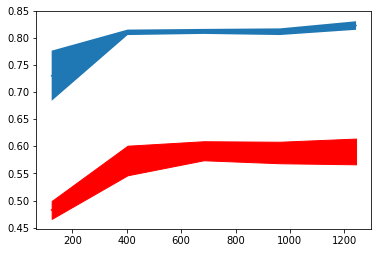

In [65]:
####
# LEARNING CURVE V2
#####################

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline




#best_feats = ['ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'airdrakes', 'cspm', 'dmgtochamps', 'draft_score', 'earthdrakes', 'elders', 'elo', 'fb', 'fbaron', 'fbarontime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firstmidouter', 'ft', 'fttime', 'gdat15', 'goldat15', 'goldspent', 'kda', 'kda2_per_min', 'net_wards_per_min', 'opp_cspm', 'opp_dmgtochamps', 'opp_earnedgpm', 'opp_net_wards', 'opp_net_wards_per_min', 'opp_wardkills', 'oppbaronkills', 'oppdragkills', 'oppelders', 'oppgoldat15', 'oppxpat10', 'teamdeaths', 'teamdragkills', 'vision_score', 'visionwards', 'waterdrakes', 'wcpm', 'win_percentage', 'xpat10']
#best_feats = ['cspm', 'dmgtochamps', 'elo', 'gdat15', 'goldspent', 'kda2_per_min', 'net_wards_per_min', 'opp_cspm', 'opp_earnedgpm', 'opp_wardkills', 'oppbaronkills', 'oppelders', 'teamdragkills', 'visionwards', 'win_percentage']
#best_feats = ['ckpm', 'cspm', 'elo', 'fbaron', 'fbarontime', 'firstmidouter', 'gamelength', 'kpm', 'net_wards', 'net_wards_per_min', 'opp_earnedgpm', 'oppgoldat15', 'teamdeaths', 'teamdragkills', 'teamtowerkills']
#best_feats = ['airdrakes', 'cspm', 'elo', 'fbarontime', 'oppelders', 'visiblewardclearrate', 'visionwardbuys', 'wcpm']
#best_feats = ['ADC_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'airdrakes', 'ckpm', 'cspm', 'dmgtochampsperminute', 'draft_score', 'earthdrakes', 'elders', 'elo', 'fb', 'fbarontime', 'fbtime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firsttothreetowers', 'ft', 'fttime', 'gdat15', 'gspd', 'herald', 'heraldtime', 'net_wards', 'okpm', 'opp_cspm', 'opp_net_wards_per_min', 'oppelders', 'oppelementals', 'oppgoldat15', 'opptowerkills', 'oppxpat10', 'visiblewardclearrate', 'vision_score', 'visionwardbuys', 'wardshare', 'waterdrakes', 'wcpm']
#best_feats = ['ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'airdrakes', 'ckpm', 'cspm', 'dmgtochampsperminute', 'draft_score', 'earthdrakes', 'elders', 'elo', 'fb', 'fbarontime', 'fbtime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firsttothreetowers', 'ft', 'fttime', 'gdat15', 'gspd', 'herald', 'heraldtime', 'kda', 'monsterkillsownjungle', 'net_wards_per_min', 'okpm', 'opp_cspm', 'opp_net_wards', 'opp_net_wards_per_min', 'oppelders', 'oppelementals', 'oppgoldat15', 'opptowerkills', 'oppxpat10', 'visiblewardclearrate', 'vision_score', 'visionwardbuys', 'wardshare', 'waterdrakes', 'wcpm', 'xpat10']

#best_feats = ['elo', 'firsttothreetowers', 'oppelementals', 'visionwardbuys', 'waterdrakes', 'wcpm']
#'''


'''
best_feats = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fbvictim', 'fd']
target_var = "result"
v = prepare_dataset(vers2,features=best_feats,dropbyodds=False, normalize=True)
X = v[best_feats]
y = v[target_var]
'''
#'''

'''
best_feats = list(pca_df.columns.values[0:8])
X = pca_df[best_feats]
y = y_pca
'''

n_feats = 50
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))
pca_df = pca_features(vers2,n_feats=n_feats)
#input_feats = pca_cols
target_var = 'result'

X = pca_df[pca_cols]
y = pca_df[target_var]


#model = LogisticRegression(tol = 0.01, C = 0.5) #{'C': 1, 'tol': 0.001} with a score of 0.66
model = RandomForestClassifier(n_estimators=500,min_samples_split=20,min_samples_leaf=20,max_features='auto',max_depth=10,bootstrap=True)
#model = LogisticRegression()
#model = SVC(C=0.1,gamma=0.05,kernel='rbf') #{'gamma': 0.05, 'C': 0.5, 'kernel': 'rbf'} with a score of 0.65
#tol': 0.1, 'C': 2

#model = RandomForestClassifier(n_estimators=1000,max_depth=10,max_features='auto',min_samples_leaf=1,min_samples_split=2,bootstrap=False)#'n_estimators': 1000, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'bootstrap': False
#model = RandomForestClassifier(bootstrap = False,max_depth = 10,max_features = 'auto', min_samples_leaf = 10,min_samples_split = 10,n_estimators = 500)
#model = RandomForestClassifier(n_estimators=100)

train_sizes, train_scores, valid_scores = learning_curve(model, X,y, cv=5)

#print(train_sizes, train_scores, valid_scores)

mean_train = np.mean(train_scores,axis=1)
error_train = np.std(train_scores,axis=1)

mean_test = np.mean(valid_scores,axis=1)
error_test = np.std(valid_scores,axis=1)

plt.plot(train_sizes,mean_test,'r-')
plt.fill_between(train_sizes,mean_test-error_test,mean_test+error_test,color='r')

plt.plot(train_sizes,mean_train)
plt.fill_between(train_sizes,mean_train-error_train,mean_train+error_train)







plt.show()


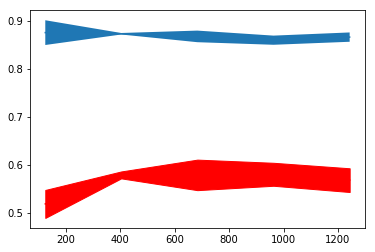

In [64]:

%matplotlib inline
plt.plot(train_sizes,mean_test,'r-')
plt.fill_between(train_sizes,mean_test-error_test,mean_test+error_test,color='r')

plt.plot(train_sizes,mean_train)
plt.fill_between(train_sizes,mean_train-error_train,mean_train+error_train)
plt.show()

In [66]:
#CHOOSE BEST PARAMS


from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 80, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

n_feats = 44
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))
pca_df = pca_features(vers2,n_feats=n_feats)
#input_feats = pca_cols
target_var = 'result'

#_v = prepare_dataset(_v,features=input_feats,dropbyodds=False,normalize=False,return_scaler=False)

#X = pca_df[['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7']]
X = pca_df[pca_cols]
y = pca_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


print(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

#best_feats = ['cspm','elo','kda2_per_min','net_wards','a','ft']

'''
best_feats = ['elo', 'firsttothreetowers', 'oppelementals', 'visionwardbuys', 'waterdrakes', 'wcpm']
target_var = "result"

vers = prepare_dataset(vers2,features=best_feats,dropbyodds=False,normalize=True)

train_features = vers[best_feats]
train_labels = vers[target_var]
'''

rf_random.fit(X_train, y_train)

print("the best parameters are %s with a score of %0.2f" %(rf_random.best_params_, rf_random.best_score_))

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 ADC_elo                     False
Jungle_elo                  False
Middle_elo                  False
Support_elo                 False
Top_elo                     False
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
draft_score                 False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
elo                         False
fb                          False
fbaron                      False
fbarontime                  Fa

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

[0.31697918 0.14022317 0.06756094 0.040772   0.03867872 0.02931893
 0.0281928  0.02352058 0.02299381 0.01872828 0.01750511 0.01621885
 0.01571187 0.01364624 0.0133094  0.0128381  0.01207224 0.01150152
 0.01066972 0.01044275 0.01002886 0.00970294 0.00898359 0.00877933
 0.00825741 0.007984   0.00763217 0.0072412  0.0064498  0.00595245
 0.00558172 0.00532158 0.00501105 0.00441133 0.00410158 0.0039874
 0.00332222 0.00311006 0.00309558 0.00269417 0.00248987 0.0020641
 0.00198046 0.001553  ] explains:  0.9906200947263849
{'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 23, 42, 61, 80, None], 'min_samples_split': [2, 5, 10, 20, 50], 'min_samples_leaf': [1, 2, 4, 10, 20], 'bootstrap': [True, False]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.3min finished


the best parameters are {'n_estimators': 650, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 23, 'bootstrap': True} with a score of 0.65


In [68]:
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=650,min_samples_split=20,min_samples_leaf=2,max_features='sqrt',max_depth=23,bootstrap=True)
rf = rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.639871382636656

In [11]:
###
# GRID SEARCH SVC
#################

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

C = [0.1,0.25,0.5, 1, 2, 4]
gamma = [0.001,0.01,0.05,0.1,0.25,'auto']
kernel = ['rbf']
#degree = [3,4,5]
grid_params = {'C': C,
               'gamma': gamma,
              'kernel': kernel}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Use the random grid to search for best hyperparameters
# First create the base model to tune

svc = SVC()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = GridSearchCV(svc, param_grid=grid_params, cv=cv)
# Fit the random search model

'''
best_feats =['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fbvictim', 'fd']
target_var = "result"
vers = prepare_dataset(vers2,features=best_feats,dropbyodds=False,normalize=True)
X = vers[best_feats]
y = vers[target_var]
'''


n_feats = 48
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))

pca_df = pca_features(_inv,n_feats=n_feats)
#input_feats = pca_cols
target_var = 'result'

#_v = prepare_dataset(_v,features=input_feats,dropbyodds=False,normalize=False,return_scaler=False)

#X = pca_df[['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7']]
X = pca_df[pca_cols]
y = pca_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


#grid.fit(best_feats, train_labels)

grid.fit(X_train, y_train)

print("the best parameters are %s with a score of %0.3f" %(grid.best_params_, grid.best_score_))



index   False
matchupWeek   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 0                            True
2                            True
3                            True
4                            True
5                            True
6                            True
a                           False
airdrakes                   False
ckpm                        False
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
fbaron                      False
fbarontime                  False
fbassist                     True
fdtime                      False
firedrake

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


input to PCA: 90
[0.33115057 0.14623657 0.06796437 0.04361296 0.03938527 0.03152909
 0.02423441 0.02230038 0.01865383 0.01696755 0.01651553 0.01523223
 0.01417384 0.01342231 0.01331156 0.01291741 0.01177554 0.01094335
 0.01047088 0.00995774 0.00960493 0.00922065 0.00867685 0.00811002
 0.00770349 0.0068777  0.00633138 0.00601121 0.005524   0.00488816
 0.00445363 0.00435421 0.00365837 0.00346923 0.00328845 0.00326232
 0.00296086 0.00291172 0.00271834 0.00247869 0.00219998 0.00210601
 0.00194582 0.00184503 0.00175168 0.0017362  0.00163271 0.00149046] explains:  0.9919675112306782
the best parameters are {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} with a score of 0.644


In [13]:
from sklearn.metrics import accuracy_score

svc = SVC(C=1,gamma='auto',kernel='rbf')
svc = svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

accuracy_score(y_test, y_pred)


0.6169154228855721

In [93]:
###
#   grid search logistic regression
##################




from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit


c_range = [0.001,0.01,0.1,0.5,1,2,5,10,25,50,100]
tol_range = [0.001,0.01,0.1,0.5,1,2,5,10,25,50,100]

g = {'C': c_range,
    'tol' : tol_range}
clf = LogisticRegression()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#best_feats = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fbvictim', 'fd']
#best_feats = ['net_earnedgpm', 'net_cspm', 'wcpm', 'Top_elo', 'elo', 'fb', 'fbarontime', 'fbvictim', 'fdtime', 'firedrakes']
#vers = prepare_dataset(vers2,features=best_feats,dropbyodds=False, normalize=True)

grid = GridSearchCV(clf, param_grid = g, cv=cv)

#X = vers[best_feats]
#y = vers[target_var]


n_feats = 46
c = np.array(['PCA']*n_feats)
pca_cols = list(np.core.defchararray.add(c , np.arange(n_feats).astype(str)))

pca_df = pca_features(vers2,n_feats=n_feats)
#input_feats = pca_cols
target_var = 'result'



#X = pca_df[['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7']]
X = pca_df[pca_cols]
y = pca_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)


#grid.fit(best_feats, train_labels)

grid.fit(X_train, y_train)

print("the best parameters are %s with a score of %0.3f" %(grid.best_params_, grid.best_score_))



index   False
matchupWeek   False
odds   False
split   False
result   False
gameid2   False
game_num   False
excluded:
 0                        True
02                       True
03                       True
04                       True
05                       True
06                       True
ADC_elo                 False
Jungle_elo              False
Middle_elo              False
Support_elo             False
Top_elo                 False
a                       False
airdrakes               False
ckpm                     True
csat10                   True
csat15                   True
csdat10                  True
csdat15                  True
cspm                    False
cssharepost15            True
d                       False
dmgtochamps             False
dmgtochampsperminute    False
draft_score             False
earnedgpm               False
earthdrakes             False
elders                  False
elementals              False
elo                     False
fbaron    

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


input to PCA: 87
[0.32907002 0.14858411 0.05931186 0.04479987 0.03818181 0.03145253
 0.02509957 0.0231166  0.01934748 0.01729504 0.0167715  0.01555729
 0.01457339 0.0137226  0.0135297  0.01325973 0.01218995 0.01134819
 0.01075202 0.01021495 0.00985107 0.009525   0.00888098 0.00836441
 0.00798067 0.00677795 0.00655309 0.00621896 0.00572224 0.00499399
 0.00452042 0.00433952 0.00376051 0.00351268 0.00340116 0.00322226
 0.00299356 0.00292137 0.00278334 0.00253479 0.00225967 0.00218384
 0.00201728 0.00191475 0.0018174  0.00179418] explains:  0.9890232974237763


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

the best parameters are {'C': 0.001, 'tol': 0.01} with a score of 0.636


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

In [94]:
from sklearn.metrics import accuracy_score

logR = LogisticRegression(C=0.001,tol=0.01)
logR = logR.fit(X_train,y_train)
y_pred = logR.predict(X_test)

accuracy_score(y_test, y_pred)


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6086235489220564

In [25]:
###
# Feature Selector
#########

'''
choose features that have high correlation with the target, lowest correlation with each other
'''

def find_top_corr_features(df,training_features,target='result',absolute_values=True,top=25,p_thresh=1.0):
    corrs = []
    pvals = []
    cols = ["features","correlation","pvalue"]
    for col in training_features:
        result = stats.pointbiserialr(df[col], df[target])
        corrs.append(result[0])
        pvals.append(result[1])
    df = pd.DataFrame(list(zip(training_features,corrs,pvals)),columns=cols)
    df = df.loc[(df["pvalue"] < p_thresh)]
    if absolute_values:
        df.loc[:,'correlation'] = df['correlation'].apply(abs)
    df = df.sort_values(by="correlation",ascending=False)
    if top == "All":
        analysis = df
    else:
        analysis = df.iloc[0:top]
    #best_features = analysis['features']
    return analysis

def trim_correlation_by_pairwise(df,top_corr,feature_col='features',thresh=0.75):
    top_corr = top_corr.set_index(feature_col)
    pw = df.astype(float).corr()
    m = pw.mask(np.eye(len(pw), dtype=bool)).abs() #.abs() > thresh).any()
    
    print(m)
    keep = []
    omit = []
    for c in m.columns.values:
        hc = m.loc[m[c]>thresh,c]
        if len(hc) > 0:
            #select top feature, check for duplication, check its not already excluded, add to keep
            feats = top_corr.loc[hc.index,'correlation'].sort_values(ascending=False)
            feat = feats.index[0]
            if not (feat in omit):
                if not (feat in keep):
                    keep.append(feat)
            
            omit_feats = list(feats.index[1:len(feats)])
            omit = omit + list(np.setdiff1d(np.array(omit_feats),np.array(omit+keep)) )
            
    print(keep)
    print(omit)
    
    _all = keep + omit
    _all = keep + list(np.setdiff1d(m.columns.values,_all))
    return _all
    

features = list(return_candidate_features(vers2))
__ = vers2[features+['result']]

top_corr = find_top_corr_features(__,features,absolute_values=True,top='All')

print(top_corr)

#print(top_corr['features'].values)
trimmed_features = trim_correlation_by_pairwise(__.loc[:,np.setdiff1d(__.columns.values, np.array(['result']))],top_corr,thresh=0.7)

print(trimmed_features)

'''
best_corr_feats = find_top_corr_features(__,trimmed_features,absolute_values=True,top=25)
print(list(best_corr_feats['features'].values))
'''

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid   False
game_num   False
excluded:
 ADC_elo                     False
Jungle_elo                  False
Middle_elo                  False
Support_elo                 False
Top_elo                     False
a                           False
airdrakes                   False
ckpm                         True
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
draft_score                 False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
elo                         False
fb                          False
fbaron                      False
fbarontime                  Fal

"\nbest_corr_feats = find_top_corr_features(__,trimmed_features,absolute_values=True,top=25)\nprint(list(best_corr_feats['features'].values))\n"

In [27]:
###
#   RFE
##############



from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn import preprocessing



#vers2 = prepare_dataset(vers2)




#train_feats = list(threshold_features_by_corr(vers2, feats, p_thresh=0.05, r_thresh=0.1, top=30, target='result'))

train_feats = list(return_candidate_features(vers2))

#train_feats = ['ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'airdrakes', 'ckpm', 'cspm', 'earthdrakes', 'elders', 'elo', 'fb', 'fbaron', 'fbarontime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firstmidouter', 'ft', 'fttime', 'gamelength', 'gdat10', 'gdat15', 'herald', 'heraldtime', 'kda', 'kpm', 'net_wards', 'net_wards_per_min', 'opp_cspm', 'opp_dmgtochamps', 'opp_earnedgpm', 'opp_net_wards_per_min', 'opp_wardkills', 'oppbaronkills', 'oppdragkills', 'oppelders', 'oppgoldat15', 'oppxpat10', 'teamdeaths', 'teamdragkills', 'teamtowerkills', 'totalgold', 'visionwardbuys', 'waterdrakes', 'wcpm', 'xpat10']
#train_feats = ['ADC_elo', 'Jungle_elo', 'Middle_elo', 'Support_elo', 'Top_elo', 'a', 'airdrakes', 'ckpm', 'cspm', 'd', 'dmgtochamps', 'dmgtochampsperminute', 'draft_score', 'earnedgpm', 'earthdrakes', 'elders', 'elementals', 'elo', 'fb', 'fbaron', 'fbarontime', 'fbvictim', 'fd', 'fdtime', 'firedrakes', 'firstmidouter', 'firsttothreetowers', 'ft', 'fttime', 'gamelength', 'gdat10', 'gdat15', 'goldat10', 'goldat15', 'goldspent', 'gspd', 'herald', 'heraldtime', 'k', 'kda', 'kda2', 'kda2_per_min', 'kpm', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'net_wards', 'net_wards_per_min', 'okpm', 'opp_cspm', 'opp_dmgtochamps', 'opp_dmgtochampsperminute', 'opp_earnedgpm', 'opp_net_wards', 'opp_net_wards_per_min', 'opp_wardkills', 'opp_wards', 'oppbaronkills', 'oppdragkills', 'oppelders', 'oppelementals', 'oppgoldat10', 'oppgoldat15', 'opptowerkills', 'oppxpat10', 'teambaronkills', 'teamdeaths', 'teamdragkills', 'teamkills', 'teamtowerkills', 'totalgold', 'vision_score', 'visionwardbuys', 'wardkills', 'wards', 'wardshare', 'waterdrakes', 'wcpm', 'win_percentage', 'wpm', 'xpat10', 'xpdat10']

train_feats = trimmed_features
print(train_feats)

X = prepare_dataset(vers2,features=train_feats,dropbyodds=False,normalize=True)

print(X.columns.values)
y = X['result']


X = X[train_feats]

#model = SVC(C=0.5,gamma='auto',kernel='linear')
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=10, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_

print(ranking)

_ = np.where(ranking == 1)

print(list(np.array(train_feats)[_]))


index   False
matchupWeek   False
odds   False
split   False
result   False
gameid   False
game_num   False
excluded:
 ADC_elo                     False
Jungle_elo                  False
Middle_elo                  False
Support_elo                 False
Top_elo                     False
a                           False
airdrakes                   False
ckpm                         True
csat10                       True
csat15                       True
csdat10                      True
csdat15                      True
cspm                        False
cssharepost15                True
d                           False
dmgtochamps                 False
dmgtochampsperminute        False
draft_score                 False
earnedgpm                   False
earthdrakes                 False
elders                      False
elementals                  False
elo                         False
fb                          False
fbaron                      False
fbarontime                  Fal

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

['index' 'ADC_elo' 'Jungle_elo' 'Middle_elo' 'Support_elo' 'Top_elo' 'a'
 'airdrakes' 'ckpm' 'csat10' 'csat15' 'csdat10' 'csdat15' 'cspm'
 'cssharepost15' 'd' 'dmgtochamps' 'dmgtochampsperminute' 'draft_score'
 'earnedgpm' 'earthdrakes' 'elders' 'elementals' 'elo' 'fb' 'fbaron'
 'fbarontime' 'fbassist' 'fbvictim' 'fd' 'fdtime' 'firedrakes'
 'firstmidouter' 'firsttothreetowers' 'ft' 'fttime' 'game_num' 'gameid'
 'gamelength' 'gdat10' 'gdat15' 'goldat10' 'goldat15' 'goldspent' 'gspd'
 'herald' 'heraldtime' 'invisiblewardclearrate' 'k' 'kda' 'kda2'
 'kda2_per_min' 'kpm' 'league' 'matchupWeek' 'minionkills' 'monsterkills'
 'monsterkillsownjungle' 'net_cspm' 'net_dmgtochamps'
 'net_dmgtochampsperminute' 'net_earnedgpm' 'net_wards'
 'net_wards_per_min' 'odds' 'okpm' 'opp_cspm' 'opp_dmgtochamps'
 'opp_dmgtochampsperminute' 'opp_earnedgpm' 'opp_net_wards'
 'opp_net_wards_per_min' 'opp_wardkills' 'opp_wards' 'oppbaronkills'
 'oppcsat10' 'oppcsat15' 'oppdragkills' 'oppelders' 'oppelementals'
 'o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarn

In [319]:
def find_correlation(data, threshold=0.7, include_negative=False):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    include_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.astype(float).corr()
    
    if include_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

features = list(return_candidate_features(vers2))
__ = vers2[features]

to_drop = find_correlation(__, threshold=0.9)
new_feats = np.setdiff1d(np.array(features),np.array(to_drop))
print(list(new_feats))

index   False
matchupWeek   False
odds   False
split   False
result   False
gameid   False
game_num   False
excluded:
 ADC_elo                 False
Jungle_elo              False
Middle_elo              False
Support_elo             False
Top_elo                 False
a                       False
airdrakes               False
ckpm                     True
csat10                   True
csat15                   True
csdat10                  True
csdat15                  True
cspm                    False
cssharepost15            True
d                       False
dmgtochamps             False
dmgtochampsperminute    False
draft_score             False
earnedgpm               False
earthdrakes             False
elders                  False
elementals              False
elo                     False
fb                      False
fbaron                  False
fbarontime              False
fbassist                 True
fbvictim                False
fd                      False
fdtime     